In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [35]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100610/bvals')

In [36]:
diff_indices = np.where(bvals_all_100206 != bvals_all_100307)[0]

In [37]:
# Diff of bvals between scan_100206 (trainset) and scan_100610 (valset) 

diff_indices

array([ 23,  28,  88,  93, 127, 130, 136, 137, 143, 147, 159, 162, 166,
       170, 184, 198, 219, 258, 268, 286])

In [30]:
# Diff of bvals between scan_100206 (trainset) and scan_100307 (testset)

diff_indices

array([ 12,  37,  69,  88,  97, 102, 137, 138, 142, 169, 173, 198, 258,
       286])

In [47]:
bvals_all_100307[127]

3010.0

In [48]:
bvals_all_100206[127]

3005.0

In [ ]:
trainset b vals  -> valset b vals 

In [ ]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [ ]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 13))

In [2]:
rand_sub_bval_indice_100206 = [ 0, 1, 2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  64,  65,  66,  67,  68,  69,  70,
        71,  72,  73,  74,  75,  76,  77,  78,  79, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 176,
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189,
       190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 207, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 284, 285, 286, 287]

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

normalized_scan_val_set_full = np.load('normalized_scan_100610_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100610/bvals')

In [6]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_val_set_sub = bvals_all_val_set[rand_sub_bval_indice_100206]*1e-3

In [7]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_val_set_sub = normalized_scan_val_set_full[:, rand_sub_bval_indice_100206]

In [8]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_val_set_sub = np.where(bvals_val_set_sub != 0.005)[0]

In [9]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_val_set_sub_no_b5 = bvals_val_set_sub[big_b_indice_val_set_sub]

In [10]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_val_set_sub_no_b5 = normalized_scan_val_set_sub[:, big_b_indice_val_set_sub]

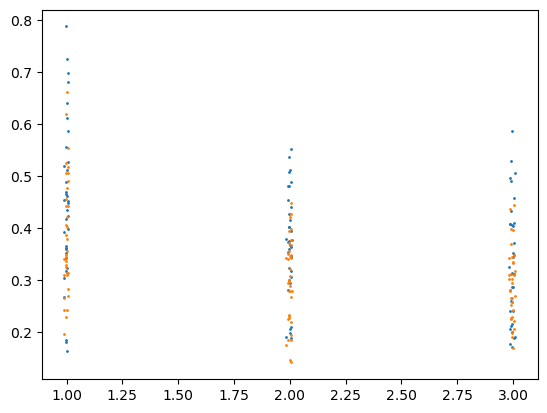

In [11]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_val_set_sub_no_b5, normalized_scan_val_set_sub_no_b5[42,:], "o", markersize = 1)

In [12]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [13]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_val_set_sub = n_val_set_all[:, rand_sub_bval_indice_100206]
n_val_set_sub_no_b5 = n_val_set_sub[:,big_b_indice_val_set_sub].T
print(n_val_set_sub_no_b5.shape)

b_values_val_set_sub_no_b5 = torch.FloatTensor(bvals_val_set_sub_no_b5)
gradient_directions_val_set_sub_no_b5 = torch.FloatTensor(n_val_set_sub_no_b5)

(105, 3)
(105, 3)


In [14]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [15]:
val_set = torch.from_numpy(normalized_scan_val_set_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 105])
<class 'torch.Tensor'>


In [16]:
# bvals_num = len(b_values_100206_sub_no_b5)
# net = network.BallStickNet(bvals_num)

# criterion = nn.MSELoss()
# optimizer = optim.Adam(net.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [17]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]


# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs_train = 0
num_bad_epochs_val = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad training epochs: {}; Bad validation epochs: {}".format(epoch, num_bad_epochs_train, num_bad_epochs_val))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    temp_model = net.state_dict()
    val_net = network.BallStickNet(gradient_directions_val_set_sub_no_b5, b_values_val_set_sub_no_b5)
    val_net.load_state_dict(temp_model)
    val_net.eval()
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = val_net(val_set)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss = val_loss.item()
        val_loss_list.append(running_val_loss)
        print("Validation Loss: {}".format(running_val_loss))

    if running_train_loss < best_train_loss:
        print("############### Saving good model for training set ###############################")
        final_model_trainset = net.state_dict()
        best_train_loss = running_train_loss
        num_bad_epochs_train = 0
        
        if running_val_loss < best_val_loss:
            print("############### Saving good model for validation set ###############################")
            final_model_valset = net.state_dict()
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
        else:
            if running_val_loss >= best_val_loss:
                num_bad_epochs_val += 1
    else:
        
        if running_train_loss >= best_train_loss:
            num_bad_epochs_train = num_bad_epochs_train + 1
            if num_bad_epochs_train == patience:
                print("Done, best training loss per epoch: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
                break
        if running_val_loss >= best_val_loss:
            num_bad_epochs_val = num_bad_epochs_val + 1
            
        if running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
            print("ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. ")

            
print("Done") 
net.load_state_dict(final_model_trainset)
net.load_state_dict(final_model_valset)

-----------------------------------------------------------------
Epoch: 0; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.05it/s]


Loss: 552.8095120531507; Average Loss: 0.07564443241011914
Validation Loss: 0.13690966367721558
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 1; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.11it/s]


Loss: 438.2906006514095; Average Loss: 0.05997408328563348
Validation Loss: 0.13524721562862396
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 2; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.46it/s]


Loss: 434.8804232738912; Average Loss: 0.05950744708181325
Validation Loss: 0.13500681519508362
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 3; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.95it/s]


Loss: 433.46692505991086; Average Loss: 0.0593140291543392
Validation Loss: 0.13486550748348236
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 4; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.76it/s]


Loss: 432.2991572674364; Average Loss: 0.05915423607928796
Validation Loss: 0.13470707833766937
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 5; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.06it/s]


Loss: 432.3062057644129; Average Loss: 0.05915520056984303
Validation Loss: 0.13459616899490356
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 6; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.05it/s]


Loss: 432.0830411342904; Average Loss: 0.05912466353780657
Validation Loss: 0.13454638421535492
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 7; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.75it/s]


Loss: 431.41954624000937; Average Loss: 0.05903387332238771
Validation Loss: 0.13454991579055786
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 8; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.01it/s]


Loss: 431.6779790460132; Average Loss: 0.05906923632266191
Validation Loss: 0.13469640910625458
-----------------------------------------------------------------
Epoch: 9; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.27it/s]


Loss: 431.15110081247985; Average Loss: 0.058997140231592755
Validation Loss: 0.1345391422510147
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 10; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.17it/s]


Loss: 431.2588525074534; Average Loss: 0.05901188457956396
Validation Loss: 0.13442672789096832
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 11; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.40it/s]


Loss: 430.76993679767475; Average Loss: 0.05894498314144427
Validation Loss: 0.1344289481639862
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 12; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.29it/s]


Loss: 430.57083663973026; Average Loss: 0.05891773900379451
Validation Loss: 0.1345839649438858
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 13; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.89it/s]


Loss: 430.51339709805325; Average Loss: 0.05890987918692573
Validation Loss: 0.13429588079452515
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 14; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.73it/s]


Loss: 429.9580555818975; Average Loss: 0.0588338882843319
Validation Loss: 0.13451683521270752
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 15; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.75it/s]


Loss: 430.39571889396757; Average Loss: 0.0588937765317416
Validation Loss: 0.13439761102199554
-----------------------------------------------------------------
Epoch: 16; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.60it/s]


Loss: 430.0010385247879; Average Loss: 0.058839769913079897
Validation Loss: 0.13444626331329346
-----------------------------------------------------------------
Epoch: 17; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.23it/s]


Loss: 429.94118983345106; Average Loss: 0.05883158043698017
Validation Loss: 0.13440224528312683
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 18; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.57it/s]


Loss: 429.6201732587069; Average Loss: 0.058787653702614524
Validation Loss: 0.1344117820262909
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 19; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.43it/s]


Loss: 429.490593241062; Average Loss: 0.05876992244677915
Validation Loss: 0.1345115751028061
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 20; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.90it/s]


Loss: 429.7373601850122; Average Loss: 0.05880368913314343
Validation Loss: 0.13446025550365448
-----------------------------------------------------------------
Epoch: 21; Bad training epochs: 1; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.64it/s]


Loss: 429.5587010285817; Average Loss: 0.05877924206740308
Validation Loss: 0.13428938388824463
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 22; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.44it/s]


Loss: 429.7238657060079; Average Loss: 0.058801842597975905
Validation Loss: 0.1345006823539734
-----------------------------------------------------------------
Epoch: 23; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.69it/s]


Loss: 429.34835345391184; Average Loss: 0.05875045887437217
Validation Loss: 0.13443905115127563
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 24; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.30it/s]


Loss: 429.2782942657359; Average Loss: 0.05874087223121728
Validation Loss: 0.13441723585128784
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 25; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.41it/s]


Loss: 428.9533927212469; Average Loss: 0.058696413891796244
Validation Loss: 0.13433308899402618
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 26; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.90it/s]


Loss: 429.17501577269286; Average Loss: 0.058726739979843026
Validation Loss: 0.1343318670988083
-----------------------------------------------------------------
Epoch: 27; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.02it/s]


Loss: 428.9466768426355; Average Loss: 0.058695494915522096
Validation Loss: 0.13423778116703033
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 28; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.33it/s]


Loss: 428.8989830361679; Average Loss: 0.05868896866942637
Validation Loss: 0.13440580666065216
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 29; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.67it/s]


Loss: 428.5362365008332; Average Loss: 0.05863933175982939
Validation Loss: 0.13420724868774414
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 30; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.86it/s]


Loss: 428.63321824232116; Average Loss: 0.058652602386743455
Validation Loss: 0.13411560654640198
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 31; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.99it/s]


Loss: 429.1936405575834; Average Loss: 0.05872928852731026
Validation Loss: 0.13421744108200073
-----------------------------------------------------------------
Epoch: 32; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.09it/s]


Loss: 428.67538615548983; Average Loss: 0.0586583724898043
Validation Loss: 0.1342044621706009
-----------------------------------------------------------------
Epoch: 33; Bad training epochs: 3; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.09it/s]


Loss: 428.8025343576446; Average Loss: 0.05867577098489937
Validation Loss: 0.1341276317834854
-----------------------------------------------------------------
Epoch: 34; Bad training epochs: 4; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.55it/s]


Loss: 428.5608205017634; Average Loss: 0.058642695744631004
Validation Loss: 0.13410040736198425
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 35; Bad training epochs: 5; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.58it/s]


Loss: 428.6471162044909; Average Loss: 0.0586545041330721
Validation Loss: 0.134102463722229
-----------------------------------------------------------------
Epoch: 36; Bad training epochs: 6; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.53it/s]


Loss: 428.30032791849226; Average Loss: 0.05860705089196665
Validation Loss: 0.13425575196743011
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 37; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.96it/s]


Loss: 428.17573019489646; Average Loss: 0.05859000139503236
Validation Loss: 0.13415591418743134
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 38; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.92it/s]


Loss: 428.1128944249358; Average Loss: 0.0585814031780153
Validation Loss: 0.13390423357486725
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 39; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.96it/s]


Loss: 427.7974149307702; Average Loss: 0.05853823411751097
Validation Loss: 0.13427886366844177
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 40; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.74it/s]


Loss: 427.92721514357254; Average Loss: 0.058555995504046596
Validation Loss: 0.13395069539546967
-----------------------------------------------------------------
Epoch: 41; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.83it/s]


Loss: 427.52447993238457; Average Loss: 0.05850088669025514
Validation Loss: 0.1339491605758667
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 42; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.92it/s]


Loss: 427.13874363712966; Average Loss: 0.05844810394596739
Validation Loss: 0.13378988206386566
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 43; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.79it/s]


Loss: 427.18139380426146; Average Loss: 0.0584539400388973
Validation Loss: 0.1339818388223648
-----------------------------------------------------------------
Epoch: 44; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.49it/s]


Loss: 426.92323036375456; Average Loss: 0.05841861389761283
Validation Loss: 0.1338534653186798
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 45; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.13it/s]


Loss: 426.8844862913247; Average Loss: 0.05841331230040021
Validation Loss: 0.13378724455833435
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 46; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.93it/s]


Loss: 426.47370806126855; Average Loss: 0.05835710290931425
Validation Loss: 0.1338188499212265
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 47; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.02it/s]


Loss: 426.6953089130111; Average Loss: 0.058387425959634795
Validation Loss: 0.1337766796350479
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 48; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.68it/s]


Loss: 426.61535269999877; Average Loss: 0.05837648504378746
Validation Loss: 0.13398167490959167
-----------------------------------------------------------------
Epoch: 49; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.40it/s]


Loss: 426.33839817903936; Average Loss: 0.05833858759975908
Validation Loss: 0.13370150327682495
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 50; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.40it/s]


Loss: 426.27874589990824; Average Loss: 0.058330424999987446
Validation Loss: 0.13381625711917877
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 51; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.36it/s]


Loss: 426.5263908235356; Average Loss: 0.05836431182588063
Validation Loss: 0.13391061127185822
-----------------------------------------------------------------
Epoch: 52; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.60it/s]


Loss: 426.1103422078304; Average Loss: 0.05830738125449239
Validation Loss: 0.13383449614048004
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 53; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.13it/s]


Loss: 426.26462970417924; Average Loss: 0.05832849339137647
Validation Loss: 0.13371238112449646
-----------------------------------------------------------------
Epoch: 54; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.19it/s]


Loss: 425.9533963762224; Average Loss: 0.05828590536073103
Validation Loss: 0.1335768699645996
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 55; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.44it/s]


Loss: 424.9232325407211; Average Loss: 0.058144941508035175
Validation Loss: 0.1336601823568344
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 56; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.69it/s]


Loss: 423.7957687245216; Average Loss: 0.05799066348173531
Validation Loss: 0.13350005447864532
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 57; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.87it/s]


Loss: 423.42129658092745; Average Loss: 0.05793942208277606
Validation Loss: 0.13346432149410248
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 58; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.65it/s]


Loss: 422.71896433318034; Average Loss: 0.05784331750590864
Validation Loss: 0.13349297642707825
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 59; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.92it/s]


Loss: 422.67426182120107; Average Loss: 0.05783720057761372
Validation Loss: 0.13341790437698364
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 60; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.26it/s]


Loss: 422.4395425717812; Average Loss: 0.057805082453719375
Validation Loss: 0.1333198994398117
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 61; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.69it/s]


Loss: 422.16608824091963; Average Loss: 0.057767663962906356
Validation Loss: 0.13330361247062683
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 62; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.87it/s]


Loss: 421.8833881339524; Average Loss: 0.05772898031389606
Validation Loss: 0.13325932621955872
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 63; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.24it/s]


Loss: 421.915829264326; Average Loss: 0.05773341943956295
Validation Loss: 0.13328102231025696
-----------------------------------------------------------------
Epoch: 64; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.91it/s]


Loss: 421.5083436605055; Average Loss: 0.05767766059941235
Validation Loss: 0.13322687149047852
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 65; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.14it/s]


Loss: 421.53619420924224; Average Loss: 0.05768147156667244
Validation Loss: 0.13324159383773804
-----------------------------------------------------------------
Epoch: 66; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.60it/s]


Loss: 421.2121040117927; Average Loss: 0.05763712424901378
Validation Loss: 0.13317328691482544
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 67; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.83it/s]


Loss: 421.1505974356551; Average Loss: 0.05762870791401958
Validation Loss: 0.13330323994159698
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 68; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.66it/s]


Loss: 420.8636318652425; Average Loss: 0.057589440594587094
Validation Loss: 0.13315990567207336
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 69; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.15it/s]


Loss: 420.6859914306551; Average Loss: 0.057565132927019036
Validation Loss: 0.133322075009346
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 70; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.98it/s]


Loss: 420.73417284339666; Average Loss: 0.05757172589537447
Validation Loss: 0.13332156836986542
-----------------------------------------------------------------
Epoch: 71; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.26it/s]


Loss: 420.4537740240339; Average Loss: 0.05753335714614586
Validation Loss: 0.13315734267234802
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 72; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.42it/s]


Loss: 420.3139811421279; Average Loss: 0.05751422839930595
Validation Loss: 0.13309982419013977
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 73; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.55it/s]


Loss: 420.13263959321193; Average Loss: 0.057489414284785434
Validation Loss: 0.13335087895393372
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 74; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.63it/s]


Loss: 420.053817095235; Average Loss: 0.057478628502358374
Validation Loss: 0.13303138315677643
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 75; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.39it/s]


Loss: 419.67949536792; Average Loss: 0.05742740768581281
Validation Loss: 0.13331611454486847
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 76; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.26it/s]


Loss: 419.5004396259319; Average Loss: 0.05740290635275477
Validation Loss: 0.13325150310993195
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 77; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.14it/s]


Loss: 419.6016507591121; Average Loss: 0.057416755714164214
Validation Loss: 0.13296645879745483
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 78; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.91it/s]


Loss: 419.1184466313571; Average Loss: 0.057350635828045574
Validation Loss: 0.1332201361656189
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 79; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.80it/s]


Loss: 419.0437164083123; Average Loss: 0.05734041001755779
Validation Loss: 0.13307155668735504
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 80; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.06it/s]


Loss: 418.8113585067913; Average Loss: 0.0573086150118762
Validation Loss: 0.13316093385219574
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 81; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.24it/s]


Loss: 418.776198706124; Average Loss: 0.05730380387330651
Validation Loss: 0.13306638598442078
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 82; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.13it/s]


Loss: 418.4652676277328; Average Loss: 0.05726125720138654
Validation Loss: 0.1330881416797638
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 83; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.20it/s]


Loss: 418.61270160856657; Average Loss: 0.057281431528265814
Validation Loss: 0.13285984098911285
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 84; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.61it/s]


Loss: 418.036580637563; Average Loss: 0.057202597241045844
Validation Loss: 0.13314573466777802
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 85; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.04it/s]


Loss: 418.04925823793747; Average Loss: 0.05720433199752839
Validation Loss: 0.1329154074192047
-----------------------------------------------------------------
Epoch: 86; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.26it/s]


Loss: 417.9051017188467; Average Loss: 0.05718460614653075
Validation Loss: 0.13291797041893005
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 87; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.74it/s]


Loss: 417.6519186720252; Average Loss: 0.05714996150410854
Validation Loss: 0.13290658593177795
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 88; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.45it/s]


Loss: 417.6531165589113; Average Loss: 0.05715012541857024
Validation Loss: 0.13298428058624268
-----------------------------------------------------------------
Epoch: 89; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.29it/s]


Loss: 417.60987307387404; Average Loss: 0.05714420813818747
Validation Loss: 0.1329279989004135
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 90; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.16it/s]


Loss: 417.52931612334214; Average Loss: 0.05713318501961442
Validation Loss: 0.13274775445461273
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 91; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.44it/s]


Loss: 417.31364835379645; Average Loss: 0.05710367383056875
Validation Loss: 0.1328061819076538
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 92; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.86it/s]


Loss: 417.29841334722005; Average Loss: 0.05710158912797209
Validation Loss: 0.13282467424869537
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 93; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.99it/s]


Loss: 417.03770671016537; Average Loss: 0.05706591498497063
Validation Loss: 0.13281483948230743
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 94; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.51it/s]


Loss: 417.09378662193194; Average Loss: 0.05707358875505363
Validation Loss: 0.13287533819675446
-----------------------------------------------------------------
Epoch: 95; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.76it/s]


Loss: 416.91311525995843; Average Loss: 0.05704886634646394
Validation Loss: 0.13276448845863342
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 96; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.09it/s]


Loss: 417.0480810974259; Average Loss: 0.05706733457819183
Validation Loss: 0.13290345668792725
-----------------------------------------------------------------
Epoch: 97; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.74it/s]


Loss: 416.73602531896904; Average Loss: 0.05702463400642707
Validation Loss: 0.13274681568145752
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 98; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.98it/s]


Loss: 416.7219074263703; Average Loss: 0.05702270216562265
Validation Loss: 0.1327408105134964
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 99; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.85it/s]


Loss: 416.81654341868125; Average Loss: 0.05703565180879601
Validation Loss: 0.13291972875595093
-----------------------------------------------------------------
Epoch: 100; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.51it/s]


Loss: 416.59003796055913; Average Loss: 0.05700465763007104
Validation Loss: 0.1328536421060562
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 101; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.79it/s]


Loss: 416.5775989065878; Average Loss: 0.0570029555154061
Validation Loss: 0.1328369528055191
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 102; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.00it/s]


Loss: 416.50100810918957; Average Loss: 0.05699247511072654
Validation Loss: 0.13278929889202118
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 103; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.66it/s]


Loss: 416.42184044630267; Average Loss: 0.05698164209719522
Validation Loss: 0.13287946581840515
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 104; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.05it/s]


Loss: 416.30476140091196; Average Loss: 0.05696562142869622
Validation Loss: 0.13269858062267303
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 105; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.42it/s]


Loss: 416.41954985586926; Average Loss: 0.05698132866117532
Validation Loss: 0.13280194997787476
-----------------------------------------------------------------
Epoch: 106; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.00it/s]


Loss: 416.39563072193414; Average Loss: 0.056978055654342386
Validation Loss: 0.1327861100435257
-----------------------------------------------------------------
Epoch: 107; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.86it/s]


Loss: 416.2424567034468; Average Loss: 0.0569570958816977
Validation Loss: 0.1329214870929718
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 108; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.33it/s]


Loss: 416.20510608004406; Average Loss: 0.05695198495895513
Validation Loss: 0.13282935321331024
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 109; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.02it/s]


Loss: 416.30464417114854; Average Loss: 0.056965605387404014
Validation Loss: 0.13269829750061035
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 110; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.41it/s]


Loss: 416.0150669568684; Average Loss: 0.056925980700173566
Validation Loss: 0.13285411894321442
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 111; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.01it/s]


Loss: 416.0629686366301; Average Loss: 0.05693253539089082
Validation Loss: 0.13262955844402313
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 112; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.58it/s]


Loss: 415.96429975284263; Average Loss: 0.056919033901593134
Validation Loss: 0.13280761241912842
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 113; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.06it/s]


Loss: 415.8828130599577; Average Loss: 0.05690788356047587
Validation Loss: 0.1326781064271927
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 114; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.19it/s]


Loss: 415.8695509398822; Average Loss: 0.0569060688204546
Validation Loss: 0.13276183605194092
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 115; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.21it/s]


Loss: 415.7970781319309; Average Loss: 0.056896151906394486
Validation Loss: 0.13260409235954285
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 116; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.12it/s]


Loss: 415.7831961964257; Average Loss: 0.05689425235309602
Validation Loss: 0.13275016844272614
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 117; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.67it/s]


Loss: 415.6992504284717; Average Loss: 0.05688276552113734
Validation Loss: 0.1328025907278061
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 118; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.13it/s]


Loss: 415.75479905237444; Average Loss: 0.056890366591731585
Validation Loss: 0.13292182981967926
-----------------------------------------------------------------
Epoch: 119; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.11it/s]


Loss: 415.65250811027363; Average Loss: 0.05687636947321752
Validation Loss: 0.13270621001720428
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 120; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.41it/s]


Loss: 415.57449630717747; Average Loss: 0.05686569462331383
Validation Loss: 0.13280610740184784
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 121; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.38it/s]


Loss: 415.3433508849703; Average Loss: 0.056834065528868404
Validation Loss: 0.13265563547611237
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 122; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.87it/s]


Loss: 415.4567675560247; Average Loss: 0.05684958505145385
Validation Loss: 0.13255146145820618
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 123; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.95it/s]


Loss: 415.4249543917831; Average Loss: 0.05684523185437645
Validation Loss: 0.13283905386924744
-----------------------------------------------------------------
Epoch: 124; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.01it/s]


Loss: 415.3049581181258; Average Loss: 0.05682881200302761
Validation Loss: 0.13275037705898285
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 125; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.89it/s]


Loss: 415.29176882468164; Average Loss: 0.05682700722833629
Validation Loss: 0.1327361911535263
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 126; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.40it/s]


Loss: 415.4705385924317; Average Loss: 0.05685146942972519
Validation Loss: 0.1326531618833542
-----------------------------------------------------------------
Epoch: 127; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.20it/s]


Loss: 415.20170240220614; Average Loss: 0.05681468286839164
Validation Loss: 0.13263916969299316
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 128; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.63it/s]


Loss: 415.2299880513456; Average Loss: 0.0568185533732
Validation Loss: 0.13274873793125153
-----------------------------------------------------------------
Epoch: 129; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.10it/s]


Loss: 415.25840173847973; Average Loss: 0.056822441398259406
Validation Loss: 0.13275521993637085
-----------------------------------------------------------------
Epoch: 130; Bad training epochs: 2; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.36it/s]


Loss: 415.0694720183965; Average Loss: 0.05679658894614073
Validation Loss: 0.13277630507946014
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 131; Bad training epochs: 0; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.77it/s]


Loss: 415.1800108826719; Average Loss: 0.056811714680168574
Validation Loss: 0.13276700675487518
-----------------------------------------------------------------
Epoch: 132; Bad training epochs: 1; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.06it/s]


Loss: 414.9437005810905; Average Loss: 0.05677937884251376
Validation Loss: 0.13274212181568146
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 133; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.73it/s]


Loss: 414.95702618849464; Average Loss: 0.05678120226990895
Validation Loss: 0.13261425495147705
-----------------------------------------------------------------
Epoch: 134; Bad training epochs: 1; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.60it/s]


Loss: 414.93395992927253; Average Loss: 0.05677804596733341
Validation Loss: 0.13266001641750336
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 135; Bad training epochs: 0; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.26it/s]


Loss: 414.8406606109347; Average Loss: 0.056765279229739285
Validation Loss: 0.1327730268239975
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 136; Bad training epochs: 0; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.68it/s]


Loss: 414.8087664656341; Average Loss: 0.05676091495150987
Validation Loss: 0.13254767656326294
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 137; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.92it/s]


Loss: 414.84021847252734; Average Loss: 0.0567652187291362
Validation Loss: 0.13264167308807373
-----------------------------------------------------------------
Epoch: 138; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.75it/s]


Loss: 414.7368369575124; Average Loss: 0.05675107238061199
Validation Loss: 0.13263092935085297
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 139; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.60it/s]


Loss: 414.8886544134002; Average Loss: 0.05677184652619051
Validation Loss: 0.1327681541442871
-----------------------------------------------------------------
Epoch: 140; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.01it/s]


Loss: 414.8021012467798; Average Loss: 0.056760002907331665
Validation Loss: 0.13248880207538605
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 141; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.20it/s]


Loss: 414.86488295788877; Average Loss: 0.05676859372713311
Validation Loss: 0.1327497363090515
-----------------------------------------------------------------
Epoch: 142; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.42it/s]


Loss: 414.76190800988115; Average Loss: 0.05675450301175166
Validation Loss: 0.13263453543186188
-----------------------------------------------------------------
Epoch: 143; Bad training epochs: 4; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.51it/s]


Loss: 414.7330917150248; Average Loss: 0.056750559895323585
Validation Loss: 0.13277341425418854
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 144; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.55it/s]


Loss: 414.6752013468649; Average Loss: 0.05674263838900724
Validation Loss: 0.13273851573467255
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 145; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.26it/s]


Loss: 414.85961467400193; Average Loss: 0.05676787283442829
Validation Loss: 0.13266010582447052
-----------------------------------------------------------------
Epoch: 146; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.33it/s]


Loss: 414.61244775750674; Average Loss: 0.056734051417283354
Validation Loss: 0.132640540599823
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 147; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.92it/s]


Loss: 414.6276820320636; Average Loss: 0.05673613601971313
Validation Loss: 0.1326739639043808
-----------------------------------------------------------------
Epoch: 148; Bad training epochs: 1; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.69it/s]


Loss: 414.71477902820334; Average Loss: 0.056748054054215014
Validation Loss: 0.13264751434326172
-----------------------------------------------------------------
Epoch: 149; Bad training epochs: 2; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.66it/s]


Loss: 414.4526348945219; Average Loss: 0.05671218320943102
Validation Loss: 0.13263165950775146
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 150; Bad training epochs: 0; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.95it/s]


Loss: 414.6000070462469; Average Loss: 0.05673234907584112
Validation Loss: 0.13260382413864136
-----------------------------------------------------------------
Epoch: 151; Bad training epochs: 1; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.37it/s]


Loss: 414.51826712605543; Average Loss: 0.056721164084025104
Validation Loss: 0.13270369172096252
-----------------------------------------------------------------
Epoch: 152; Bad training epochs: 2; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.51it/s]


Loss: 414.43304134812206; Average Loss: 0.05670950210018091
Validation Loss: 0.1326678842306137
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 153; Bad training epochs: 0; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.20it/s]


Loss: 414.5134494388476; Average Loss: 0.05672050484932233
Validation Loss: 0.1327265352010727
-----------------------------------------------------------------
Epoch: 154; Bad training epochs: 1; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.34it/s]


Loss: 414.4872352867387; Average Loss: 0.056716917800593694
Validation Loss: 0.13270731270313263
-----------------------------------------------------------------
Epoch: 155; Bad training epochs: 2; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.27it/s]


Loss: 414.4528405589517; Average Loss: 0.056712211351799637
Validation Loss: 0.1327207386493683
-----------------------------------------------------------------
Epoch: 156; Bad training epochs: 3; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.48it/s]


Loss: 414.503081033472; Average Loss: 0.05671908607464039
Validation Loss: 0.13266272842884064
-----------------------------------------------------------------
Epoch: 157; Bad training epochs: 4; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.41it/s]


Loss: 414.35425271163695; Average Loss: 0.056698720951236584
Validation Loss: 0.13267254829406738
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 158; Bad training epochs: 0; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.55it/s]


Loss: 414.4655258068815; Average Loss: 0.05671394715474569
Validation Loss: 0.13253329694271088
-----------------------------------------------------------------
Epoch: 159; Bad training epochs: 1; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.80it/s]


Loss: 414.3302906898316; Average Loss: 0.056695442075784294
Validation Loss: 0.1327572464942932
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 160; Bad training epochs: 0; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.07it/s]


Loss: 414.3647284209728; Average Loss: 0.056700154409000114
Validation Loss: 0.13268175721168518
-----------------------------------------------------------------
Epoch: 161; Bad training epochs: 1; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.16it/s]


Loss: 414.31694662268274; Average Loss: 0.056693616122425114
Validation Loss: 0.13258500397205353
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 162; Bad training epochs: 0; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.62it/s]


Loss: 414.2654083503876; Average Loss: 0.05668656381368194
Validation Loss: 0.13252562284469604
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 163; Bad training epochs: 0; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.95it/s]


Loss: 414.19784384407103; Average Loss: 0.05667731853367146
Validation Loss: 0.13251620531082153
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 164; Bad training epochs: 0; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.36it/s]


Loss: 414.26525278110057; Average Loss: 0.056686542526149505
Validation Loss: 0.132699117064476
-----------------------------------------------------------------
Epoch: 165; Bad training epochs: 1; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.09it/s]


Loss: 414.34007472288795; Average Loss: 0.056696780887094685
Validation Loss: 0.13250946998596191
-----------------------------------------------------------------
Epoch: 166; Bad training epochs: 2; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.68it/s]


Loss: 414.17481203423813; Average Loss: 0.056674166945024376
Validation Loss: 0.1324562430381775
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 167; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.33it/s]


Loss: 414.08858462329954; Average Loss: 0.05666236790138198
Validation Loss: 0.13264422118663788
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 168; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.12it/s]


Loss: 414.13641897728667; Average Loss: 0.05666891337948641
Validation Loss: 0.1326061487197876
-----------------------------------------------------------------
Epoch: 169; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.54it/s]


Loss: 414.1300225947052; Average Loss: 0.05666803812188085
Validation Loss: 0.13263362646102905
-----------------------------------------------------------------
Epoch: 170; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.09it/s]


Loss: 414.14134181151167; Average Loss: 0.05666958700212256
Validation Loss: 0.13272325694561005
-----------------------------------------------------------------
Epoch: 171; Bad training epochs: 3; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.76it/s]


Loss: 414.08121495041996; Average Loss: 0.05666135946229064
Validation Loss: 0.13265740871429443
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 172; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.34it/s]


Loss: 414.0687474296428; Average Loss: 0.05665965345233208
Validation Loss: 0.13247233629226685
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 173; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.26it/s]


Loss: 414.14511235430837; Average Loss: 0.05667010294941275
Validation Loss: 0.13257350027561188
-----------------------------------------------------------------
Epoch: 174; Bad training epochs: 1; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.76it/s]


Loss: 414.16456830734387; Average Loss: 0.05667276523088997
Validation Loss: 0.13247166574001312
-----------------------------------------------------------------
Epoch: 175; Bad training epochs: 2; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.94it/s]


Loss: 414.15669241664; Average Loss: 0.05667168752280241
Validation Loss: 0.1326344609260559
-----------------------------------------------------------------
Epoch: 176; Bad training epochs: 3; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.98it/s]


Loss: 413.95893895067275; Average Loss: 0.05664462766155894
Validation Loss: 0.13259215652942657
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 177; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.55it/s]


Loss: 413.9947841875255; Average Loss: 0.05664953259271011
Validation Loss: 0.1325383186340332
-----------------------------------------------------------------
Epoch: 178; Bad training epochs: 1; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.73it/s]


Loss: 413.9327060522046; Average Loss: 0.056641038047647044
Validation Loss: 0.13249272108078003
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 179; Bad training epochs: 0; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.98it/s]


Loss: 414.0646822641138; Average Loss: 0.05665909718994442
Validation Loss: 0.132755845785141
-----------------------------------------------------------------
Epoch: 180; Bad training epochs: 1; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.79it/s]


Loss: 414.10475707263686; Average Loss: 0.05666458088021851
Validation Loss: 0.13263075053691864
-----------------------------------------------------------------
Epoch: 181; Bad training epochs: 2; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.75it/s]


Loss: 414.01039122161455; Average Loss: 0.05665166820219137
Validation Loss: 0.13269834220409393
-----------------------------------------------------------------
Epoch: 182; Bad training epochs: 3; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.97it/s]


Loss: 413.8178971677553; Average Loss: 0.05662532801967095
Validation Loss: 0.13272859156131744
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 183; Bad training epochs: 0; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.23it/s]


Loss: 413.9120859852992; Average Loss: 0.05663821647308418
Validation Loss: 0.13264663517475128
-----------------------------------------------------------------
Epoch: 184; Bad training epochs: 1; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.11it/s]


Loss: 414.01269730436616; Average Loss: 0.05665198375812345
Validation Loss: 0.13275055587291718
-----------------------------------------------------------------
Epoch: 185; Bad training epochs: 2; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.92it/s]


Loss: 413.9352063876577; Average Loss: 0.05664138018440855
Validation Loss: 0.13262715935707092
-----------------------------------------------------------------
Epoch: 186; Bad training epochs: 3; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.47it/s]


Loss: 413.8869469463825; Average Loss: 0.05663477653891386
Validation Loss: 0.132646381855011
-----------------------------------------------------------------
Epoch: 187; Bad training epochs: 4; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.57it/s]


Loss: 413.9035525706131; Average Loss: 0.05663704879181898
Validation Loss: 0.13271020352840424
-----------------------------------------------------------------
Epoch: 188; Bad training epochs: 5; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.96it/s]


Loss: 413.85054853884503; Average Loss: 0.05662979591390874
Validation Loss: 0.13261233270168304
-----------------------------------------------------------------
Epoch: 189; Bad training epochs: 6; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.18it/s]


Loss: 413.7513629763853; Average Loss: 0.05661622372419065
Validation Loss: 0.13261526823043823
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 190; Bad training epochs: 0; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.57it/s]


Loss: 413.79856769903563; Average Loss: 0.05662268304584505
Validation Loss: 0.1326739341020584
-----------------------------------------------------------------
Epoch: 191; Bad training epochs: 1; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.90it/s]


Loss: 413.72385109961033; Average Loss: 0.056612459099563535
Validation Loss: 0.13265496492385864
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 192; Bad training epochs: 0; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.25it/s]


Loss: 413.694934965577; Average Loss: 0.05660850232150752
Validation Loss: 0.13270172476768494
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 193; Bad training epochs: 0; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.13it/s]


Loss: 413.83861611946486; Average Loss: 0.05662816312526887
Validation Loss: 0.13270270824432373
-----------------------------------------------------------------
Epoch: 194; Bad training epochs: 1; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.03it/s]


Loss: 413.695803694427; Average Loss: 0.05660862119518706
Validation Loss: 0.13260677456855774
-----------------------------------------------------------------
Epoch: 195; Bad training epochs: 2; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.27it/s]


Loss: 413.85636088531464; Average Loss: 0.05663059125414815
Validation Loss: 0.13253970444202423
-----------------------------------------------------------------
Epoch: 196; Bad training epochs: 3; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.79it/s]


Loss: 413.6576923902612; Average Loss: 0.056603406183670116
Validation Loss: 0.13258425891399384
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 197; Bad training epochs: 0; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.48it/s]


Loss: 413.7853528051637; Average Loss: 0.0566208747680848
Validation Loss: 0.13253457844257355
-----------------------------------------------------------------
Epoch: 198; Bad training epochs: 1; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.00it/s]


Loss: 413.74132450297475; Average Loss: 0.05661485009619249
Validation Loss: 0.13268554210662842
-----------------------------------------------------------------
Epoch: 199; Bad training epochs: 2; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.17it/s]


Loss: 413.7033183290623; Average Loss: 0.05660964947031504
Validation Loss: 0.13267455995082855
-----------------------------------------------------------------
Epoch: 200; Bad training epochs: 3; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.30it/s]


Loss: 413.749395448016; Average Loss: 0.05661595449480241
Validation Loss: 0.132671520113945
-----------------------------------------------------------------
Epoch: 201; Bad training epochs: 4; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.85it/s]


Loss: 413.6906181324739; Average Loss: 0.056607911621849194
Validation Loss: 0.13273806869983673
-----------------------------------------------------------------
Epoch: 202; Bad training epochs: 5; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.19it/s]


Loss: 413.8663851749152; Average Loss: 0.056631962941285606
Validation Loss: 0.13264502584934235
-----------------------------------------------------------------
Epoch: 203; Bad training epochs: 6; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.01it/s]


Loss: 413.7086561040487; Average Loss: 0.056610379871927845
Validation Loss: 0.13275323808193207
-----------------------------------------------------------------
Epoch: 204; Bad training epochs: 7; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.06it/s]


Loss: 413.659009776311; Average Loss: 0.056603586449960455
Validation Loss: 0.1326746940612793
-----------------------------------------------------------------
Epoch: 205; Bad training epochs: 8; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.26it/s]


Loss: 413.61872470285743; Average Loss: 0.056598073987802054
Validation Loss: 0.13268983364105225
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 206; Bad training epochs: 0; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.31it/s]


Loss: 413.6403311698232; Average Loss: 0.05660103053774264
Validation Loss: 0.13271202147006989
-----------------------------------------------------------------
Epoch: 207; Bad training epochs: 1; Bad validation epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.86it/s]


Loss: 413.69004608294927; Average Loss: 0.056607833344683806
Validation Loss: 0.1327114999294281
-----------------------------------------------------------------
Epoch: 208; Bad training epochs: 2; Bad validation epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.38it/s]


Loss: 413.5299021282699; Average Loss: 0.056585919831454556
Validation Loss: 0.1325901597738266
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 209; Bad training epochs: 0; Bad validation epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.36it/s]


Loss: 413.6101690696087; Average Loss: 0.05659690326622998
Validation Loss: 0.13260620832443237
-----------------------------------------------------------------
Epoch: 210; Bad training epochs: 1; Bad validation epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.85it/s]


Loss: 413.6288683991879; Average Loss: 0.05659946201411986
Validation Loss: 0.1326228380203247
-----------------------------------------------------------------
Epoch: 211; Bad training epochs: 2; Bad validation epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.01it/s]


Loss: 413.55753370700404; Average Loss: 0.0565897008356601
Validation Loss: 0.13264547288417816
-----------------------------------------------------------------
Epoch: 212; Bad training epochs: 3; Bad validation epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.36it/s]


Loss: 413.4864436404314; Average Loss: 0.056579973130874574
Validation Loss: 0.13273276388645172
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 213; Bad training epochs: 0; Bad validation epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.15it/s]


Loss: 413.50412562536076; Average Loss: 0.05658239266904225
Validation Loss: 0.1327114999294281
-----------------------------------------------------------------
Epoch: 214; Bad training epochs: 1; Bad validation epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.75it/s]


Loss: 413.6882945431862; Average Loss: 0.05660759367038673
Validation Loss: 0.1326918751001358
-----------------------------------------------------------------
Epoch: 215; Bad training epochs: 2; Bad validation epochs: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.34it/s]


Loss: 413.5408036378212; Average Loss: 0.05658741155416273
Validation Loss: 0.1326422542333603
-----------------------------------------------------------------
Epoch: 216; Bad training epochs: 3; Bad validation epochs: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.03it/s]


Loss: 413.54569119168445; Average Loss: 0.05658808034916317
Validation Loss: 0.13267135620117188
-----------------------------------------------------------------
Epoch: 217; Bad training epochs: 4; Bad validation epochs: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.11it/s]


Loss: 413.60380095918663; Average Loss: 0.056596031877283334
Validation Loss: 0.13261491060256958
-----------------------------------------------------------------
Epoch: 218; Bad training epochs: 5; Bad validation epochs: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.96it/s]


Loss: 413.5681025334634; Average Loss: 0.05659114703523035
Validation Loss: 0.13267002999782562
-----------------------------------------------------------------
Epoch: 219; Bad training epochs: 6; Bad validation epochs: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.55it/s]


Loss: 413.4476261276286; Average Loss: 0.056574661484349836
Validation Loss: 0.13270364701747894
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 220; Bad training epochs: 0; Bad validation epochs: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.35it/s]


Loss: 413.4972978439182; Average Loss: 0.05658145838039384
Validation Loss: 0.1326395869255066
-----------------------------------------------------------------
Epoch: 221; Bad training epochs: 1; Bad validation epochs: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.22it/s]


Loss: 413.39938281918876; Average Loss: 0.05656806004641335
Validation Loss: 0.1326514482498169
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 222; Bad training epochs: 0; Bad validation epochs: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.95it/s]


Loss: 413.4168391940184; Average Loss: 0.056570448712919864
Validation Loss: 0.13265186548233032
-----------------------------------------------------------------
Epoch: 223; Bad training epochs: 1; Bad validation epochs: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.45it/s]


Loss: 413.3973987803329; Average Loss: 0.05656778855779049
Validation Loss: 0.13266022503376007
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 224; Bad training epochs: 0; Bad validation epochs: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.60it/s]


Loss: 413.5188952689059; Average Loss: 0.056584413693063204
Validation Loss: 0.13268984854221344
-----------------------------------------------------------------
Epoch: 225; Bad training epochs: 1; Bad validation epochs: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.80it/s]


Loss: 413.3454653774388; Average Loss: 0.05656068218082085
Validation Loss: 0.13260573148727417
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 226; Bad training epochs: 0; Bad validation epochs: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.29it/s]


Loss: 413.37704764772207; Average Loss: 0.0565650037832132
Validation Loss: 0.13268549740314484
-----------------------------------------------------------------
Epoch: 227; Bad training epochs: 1; Bad validation epochs: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.52it/s]


Loss: 413.562940380536; Average Loss: 0.056590440665097975
Validation Loss: 0.13262034952640533
-----------------------------------------------------------------
Epoch: 228; Bad training epochs: 2; Bad validation epochs: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.52it/s]


Loss: 413.400443241233; Average Loss: 0.0565682051506887
Validation Loss: 0.13273467123508453
-----------------------------------------------------------------
Epoch: 229; Bad training epochs: 3; Bad validation epochs: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.06it/s]


Loss: 413.35421875235625; Average Loss: 0.05656187996063988
Validation Loss: 0.1327017843723297
-----------------------------------------------------------------
Epoch: 230; Bad training epochs: 4; Bad validation epochs: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.24it/s]


Loss: 413.51509587373585; Average Loss: 0.05658389379771974
Validation Loss: 0.13272017240524292
-----------------------------------------------------------------
Epoch: 231; Bad training epochs: 5; Bad validation epochs: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.00it/s]


Loss: 413.3368824175559; Average Loss: 0.05655950771997207
Validation Loss: 0.13260099291801453
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 232; Bad training epochs: 0; Bad validation epochs: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.70it/s]


Loss: 413.41984307719395; Average Loss: 0.05657085975331061
Validation Loss: 0.13265539705753326
-----------------------------------------------------------------
Epoch: 233; Bad training epochs: 1; Bad validation epochs: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.59it/s]


Loss: 413.392978860531; Average Loss: 0.0565671837521252
Validation Loss: 0.13267497718334198
-----------------------------------------------------------------
Epoch: 234; Bad training epochs: 2; Bad validation epochs: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.59it/s]


Loss: 413.3068259982392; Average Loss: 0.056555394909447075
Validation Loss: 0.1326650083065033
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 235; Bad training epochs: 0; Bad validation epochs: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.23it/s]


Loss: 413.2774048051797; Average Loss: 0.05655136902096055
Validation Loss: 0.13271377980709076
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 236; Bad training epochs: 0; Bad validation epochs: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.87it/s]


Loss: 413.40370543766767; Average Loss: 0.05656865153772136
Validation Loss: 0.13263489305973053
-----------------------------------------------------------------
Epoch: 237; Bad training epochs: 1; Bad validation epochs: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.52it/s]


Loss: 413.38476699613966; Average Loss: 0.056566060070626666
Validation Loss: 0.13263732194900513
-----------------------------------------------------------------
Epoch: 238; Bad training epochs: 2; Bad validation epochs: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.84it/s]


Loss: 413.2646298168693; Average Loss: 0.05654962093826892
Validation Loss: 0.13260602951049805
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 239; Bad training epochs: 0; Bad validation epochs: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.70it/s]


Loss: 413.23520663613454; Average Loss: 0.056545594777796186
Validation Loss: 0.13268731534481049
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 240; Bad training epochs: 0; Bad validation epochs: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.30it/s]


Loss: 413.2274387769867; Average Loss: 0.05654453185235176
Validation Loss: 0.13268102705478668
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 241; Bad training epochs: 0; Bad validation epochs: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.18it/s]


Loss: 413.28564339410514; Average Loss: 0.05655249635934662
Validation Loss: 0.13267871737480164
-----------------------------------------------------------------
Epoch: 242; Bad training epochs: 1; Bad validation epochs: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.21it/s]


Loss: 413.3113823700696; Average Loss: 0.05655601838670903
Validation Loss: 0.1327075958251953
-----------------------------------------------------------------
Epoch: 243; Bad training epochs: 2; Bad validation epochs: 76


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.24it/s]


Loss: 413.2986539416015; Average Loss: 0.056554276675095994
Validation Loss: 0.1326211392879486
-----------------------------------------------------------------
Epoch: 244; Bad training epochs: 3; Bad validation epochs: 77


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.03it/s]


Loss: 413.3819939540699; Average Loss: 0.056565680617688824
Validation Loss: 0.13264484703540802
-----------------------------------------------------------------
Epoch: 245; Bad training epochs: 4; Bad validation epochs: 78


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.79it/s]


Loss: 413.33960327575915; Average Loss: 0.056559880032260416
Validation Loss: 0.1326579749584198
-----------------------------------------------------------------
Epoch: 246; Bad training epochs: 5; Bad validation epochs: 79


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.03it/s]


Loss: 413.2435443357099; Average Loss: 0.05654673567812122
Validation Loss: 0.13267633318901062
-----------------------------------------------------------------
Epoch: 247; Bad training epochs: 6; Bad validation epochs: 80


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.85it/s]


Loss: 413.19581429008394; Average Loss: 0.056540204473191566
Validation Loss: 0.13266050815582275
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 248; Bad training epochs: 0; Bad validation epochs: 81


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.54it/s]


Loss: 413.22491266625; Average Loss: 0.05654418618859469
Validation Loss: 0.13269247114658356
-----------------------------------------------------------------
Epoch: 249; Bad training epochs: 1; Bad validation epochs: 82


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.46it/s]


Loss: 413.20867832330987; Average Loss: 0.05654196474046386
Validation Loss: 0.13261550664901733
-----------------------------------------------------------------
Epoch: 250; Bad training epochs: 2; Bad validation epochs: 83


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.89it/s]


Loss: 413.1514897677116; Average Loss: 0.05653413926761243
Validation Loss: 0.13260841369628906
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 251; Bad training epochs: 0; Bad validation epochs: 84


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.52it/s]


Loss: 413.14634126843885; Average Loss: 0.05653343476579623
Validation Loss: 0.13266399502754211
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 252; Bad training epochs: 0; Bad validation epochs: 85


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.93it/s]


Loss: 413.2614464154467; Average Loss: 0.056549185333257625
Validation Loss: 0.1326373964548111
-----------------------------------------------------------------
Epoch: 253; Bad training epochs: 1; Bad validation epochs: 86


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.50it/s]


Loss: 413.1274085876066; Average Loss: 0.056530844086974084
Validation Loss: 0.13258692622184753
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 254; Bad training epochs: 0; Bad validation epochs: 87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.80it/s]


Loss: 413.1655384062324; Average Loss: 0.05653606163194203
Validation Loss: 0.13260212540626526
-----------------------------------------------------------------
Epoch: 255; Bad training epochs: 1; Bad validation epochs: 88


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.45it/s]


Loss: 413.1960742690135; Average Loss: 0.05654024004775773
Validation Loss: 0.13260944187641144
-----------------------------------------------------------------
Epoch: 256; Bad training epochs: 2; Bad validation epochs: 89


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.84it/s]


Loss: 413.138620656915; Average Loss: 0.056532378305543925
Validation Loss: 0.13265559077262878
-----------------------------------------------------------------
Epoch: 257; Bad training epochs: 3; Bad validation epochs: 90


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.42it/s]


Loss: 413.1579142261762; Average Loss: 0.056535018367019185
Validation Loss: 0.13270887732505798
-----------------------------------------------------------------
Epoch: 258; Bad training epochs: 4; Bad validation epochs: 91


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.63it/s]


Loss: 413.1541230333969; Average Loss: 0.05653449959406088
Validation Loss: 0.13263531029224396
-----------------------------------------------------------------
Epoch: 259; Bad training epochs: 5; Bad validation epochs: 92


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.97it/s]


Loss: 413.09137258748524; Average Loss: 0.056525913052474716
Validation Loss: 0.13264036178588867
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 260; Bad training epochs: 0; Bad validation epochs: 93


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.25it/s]


Loss: 413.14535802439786; Average Loss: 0.056533300222276664
Validation Loss: 0.13265925645828247
-----------------------------------------------------------------
Epoch: 261; Bad training epochs: 1; Bad validation epochs: 94


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.24it/s]


Loss: 413.1008777413517; Average Loss: 0.05652721370297643
Validation Loss: 0.13262008130550385
-----------------------------------------------------------------
Epoch: 262; Bad training epochs: 2; Bad validation epochs: 95


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.25it/s]


Loss: 413.1294384438079; Average Loss: 0.05653112184507497
Validation Loss: 0.13259589672088623
-----------------------------------------------------------------
Epoch: 263; Bad training epochs: 3; Bad validation epochs: 96


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.51it/s]


Loss: 413.1977177122608; Average Loss: 0.056540464930522824
Validation Loss: 0.13257136940956116
-----------------------------------------------------------------
Epoch: 264; Bad training epochs: 4; Bad validation epochs: 97


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.54it/s]


Loss: 413.05583187099546; Average Loss: 0.05652104979077661
Validation Loss: 0.1325889527797699
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 265; Bad training epochs: 0; Bad validation epochs: 98


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.46it/s]


Loss: 413.11815299326554; Average Loss: 0.05652957758528538
Validation Loss: 0.13265389204025269
-----------------------------------------------------------------
Epoch: 266; Bad training epochs: 1; Bad validation epochs: 99


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.29it/s]


Loss: 413.1435682501178; Average Loss: 0.056533055316108076
Validation Loss: 0.13267318904399872
-----------------------------------------------------------------
Epoch: 267; Bad training epochs: 2; Bad validation epochs: 100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.57it/s]


Loss: 413.0796448716428; Average Loss: 0.0565243082747185
Validation Loss: 0.13267260789871216
-----------------------------------------------------------------
Epoch: 268; Bad training epochs: 3; Bad validation epochs: 101


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.24it/s]


Loss: 413.0346516217105; Average Loss: 0.05651815156290511
Validation Loss: 0.13258400559425354
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 269; Bad training epochs: 0; Bad validation epochs: 102


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.08it/s]


Loss: 413.0252488537226; Average Loss: 0.05651686492251267
Validation Loss: 0.13253222405910492
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 270; Bad training epochs: 0; Bad validation epochs: 103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.19it/s]


Loss: 413.07509536948055; Average Loss: 0.05652368573747681
Validation Loss: 0.13259820640087128
-----------------------------------------------------------------
Epoch: 271; Bad training epochs: 1; Bad validation epochs: 104


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.29it/s]


Loss: 413.04539237054996; Average Loss: 0.05651962128770525
Validation Loss: 0.13259996473789215
-----------------------------------------------------------------
Epoch: 272; Bad training epochs: 2; Bad validation epochs: 105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.73it/s]


Loss: 413.12357736122794; Average Loss: 0.05653031983596442
Validation Loss: 0.1325983852148056
-----------------------------------------------------------------
Epoch: 273; Bad training epochs: 3; Bad validation epochs: 106


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.12it/s]


Loss: 412.999080437934; Average Loss: 0.05651328413217488
Validation Loss: 0.13257180154323578
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 274; Bad training epochs: 0; Bad validation epochs: 107


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.59it/s]


Loss: 412.99446460511535; Average Loss: 0.05651265251848869
Validation Loss: 0.13261443376541138
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 275; Bad training epochs: 0; Bad validation epochs: 108


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.10it/s]


Loss: 413.0070980985183; Average Loss: 0.05651438123953453
Validation Loss: 0.13254930078983307
-----------------------------------------------------------------
Epoch: 276; Bad training epochs: 1; Bad validation epochs: 109


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.03it/s]


Loss: 413.1031033832114; Average Loss: 0.05652751825167097
Validation Loss: 0.1325586438179016
-----------------------------------------------------------------
Epoch: 277; Bad training epochs: 2; Bad validation epochs: 110


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.23it/s]


Loss: 412.9689175663516; Average Loss: 0.056509156755111055
Validation Loss: 0.13254059851169586
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 278; Bad training epochs: 0; Bad validation epochs: 111


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.14it/s]


Loss: 413.00469042151235; Average Loss: 0.05651405178181614
Validation Loss: 0.132558673620224
-----------------------------------------------------------------
Epoch: 279; Bad training epochs: 1; Bad validation epochs: 112


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.96it/s]


Loss: 413.04245878430083; Average Loss: 0.05651921986648889
Validation Loss: 0.13252998888492584
-----------------------------------------------------------------
Epoch: 280; Bad training epochs: 2; Bad validation epochs: 113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.36it/s]


Loss: 412.95804591919295; Average Loss: 0.05650766911866351
Validation Loss: 0.13255371153354645
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 281; Bad training epochs: 0; Bad validation epochs: 114


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.45it/s]


Loss: 412.97876279009506; Average Loss: 0.056510503939531345
Validation Loss: 0.13262535631656647
-----------------------------------------------------------------
Epoch: 282; Bad training epochs: 1; Bad validation epochs: 115


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.04it/s]


Loss: 412.9989723134786; Average Loss: 0.05651326933681973
Validation Loss: 0.13252370059490204
-----------------------------------------------------------------
Epoch: 283; Bad training epochs: 2; Bad validation epochs: 116


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.70it/s]


Loss: 412.94500134233385; Average Loss: 0.05650588414646057
Validation Loss: 0.13255444169044495
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 284; Bad training epochs: 0; Bad validation epochs: 117


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.81it/s]


Loss: 412.96238601394; Average Loss: 0.05650826300136015
Validation Loss: 0.13254572451114655
-----------------------------------------------------------------
Epoch: 285; Bad training epochs: 1; Bad validation epochs: 118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.97it/s]


Loss: 413.0279467490036; Average Loss: 0.056517234092638695
Validation Loss: 0.13253039121627808
-----------------------------------------------------------------
Epoch: 286; Bad training epochs: 2; Bad validation epochs: 119


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.72it/s]


Loss: 412.96529527567327; Average Loss: 0.056508661094098696
Validation Loss: 0.13254234194755554
-----------------------------------------------------------------
Epoch: 287; Bad training epochs: 3; Bad validation epochs: 120


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.70it/s]


Loss: 412.9313848800957; Average Loss: 0.05650402091955333
Validation Loss: 0.13264131546020508
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 288; Bad training epochs: 0; Bad validation epochs: 121


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.02it/s]


Loss: 412.9607570588123; Average Loss: 0.05650804010109638
Validation Loss: 0.13245022296905518
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 289; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.56it/s]


Loss: 413.007213186007; Average Loss: 0.056514396987685685
Validation Loss: 0.13258743286132812
-----------------------------------------------------------------
Epoch: 290; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.76it/s]


Loss: 412.96982168219984; Average Loss: 0.05650928047101804
Validation Loss: 0.13257881999015808
-----------------------------------------------------------------
Epoch: 291; Bad training epochs: 3; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.34it/s]


Loss: 412.9934368818067; Average Loss: 0.056512511888588766
Validation Loss: 0.13258805871009827
-----------------------------------------------------------------
Epoch: 292; Bad training epochs: 4; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.59it/s]


Loss: 412.97456331248395; Average Loss: 0.056509929298369455
Validation Loss: 0.1325647085905075
-----------------------------------------------------------------
Epoch: 293; Bad training epochs: 5; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.86it/s]


Loss: 412.9199611484073; Average Loss: 0.0565024577378773
Validation Loss: 0.132481187582016
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 294; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.39it/s]


Loss: 412.9996313571464; Average Loss: 0.056513359517945595
Validation Loss: 0.13253915309906006
-----------------------------------------------------------------
Epoch: 295; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.18it/s]


Loss: 412.9046406520065; Average Loss: 0.05650036133716564
Validation Loss: 0.13262882828712463
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 296; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.62it/s]


Loss: 412.894954059273; Average Loss: 0.05649903585923276
Validation Loss: 0.1324687898159027
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 297; Bad training epochs: 0; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.73it/s]


Loss: 412.9124365490861; Average Loss: 0.05650142809921813
Validation Loss: 0.13253678381443024
-----------------------------------------------------------------
Epoch: 298; Bad training epochs: 1; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.03it/s]


Loss: 412.8704310900066; Average Loss: 0.05649568022578087
Validation Loss: 0.1326221525669098
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 299; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.63it/s]


Loss: 412.85954864672385; Average Loss: 0.056494191112031175
Validation Loss: 0.13255327939987183
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 300; Bad training epochs: 0; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.91it/s]


Loss: 412.94496911228634; Average Loss: 0.05650587973621871
Validation Loss: 0.1325228363275528
-----------------------------------------------------------------
Epoch: 301; Bad training epochs: 1; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.59it/s]


Loss: 412.9194423004519; Average Loss: 0.05650238674062013
Validation Loss: 0.132564514875412
-----------------------------------------------------------------
Epoch: 302; Bad training epochs: 2; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.02it/s]


Loss: 412.8930368111469; Average Loss: 0.056498773510009155
Validation Loss: 0.13263314962387085
-----------------------------------------------------------------
Epoch: 303; Bad training epochs: 3; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.01it/s]


Loss: 412.83829352934845; Average Loss: 0.056491282639483914
Validation Loss: 0.13256941735744476
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 304; Bad training epochs: 0; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.71it/s]


Loss: 412.83434464456514; Average Loss: 0.056490742288528344
Validation Loss: 0.13253013789653778
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 305; Bad training epochs: 0; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 251.38it/s]


Loss: 412.82941931230016; Average Loss: 0.05649006832406953
Validation Loss: 0.13250939548015594
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 306; Bad training epochs: 0; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.23it/s]


Loss: 412.84125337493606; Average Loss: 0.056491687653932136
Validation Loss: 0.13257135450839996
-----------------------------------------------------------------
Epoch: 307; Bad training epochs: 1; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.39it/s]


Loss: 412.879142832011; Average Loss: 0.056496872308704295
Validation Loss: 0.13246287405490875
-----------------------------------------------------------------
Epoch: 308; Bad training epochs: 2; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.03it/s]


Loss: 412.9023596381303; Average Loss: 0.056500049211566816
Validation Loss: 0.13252019882202148
-----------------------------------------------------------------
Epoch: 309; Bad training epochs: 3; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.54it/s]


Loss: 412.843053343473; Average Loss: 0.056491933955045565
Validation Loss: 0.13258439302444458
-----------------------------------------------------------------
Epoch: 310; Bad training epochs: 4; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.45it/s]


Loss: 412.9084004466422; Average Loss: 0.056500875813716774
Validation Loss: 0.13261239230632782
-----------------------------------------------------------------
Epoch: 311; Bad training epochs: 5; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.76it/s]


Loss: 412.872965027811; Average Loss: 0.05649602696056527
Validation Loss: 0.13261006772518158
-----------------------------------------------------------------
Epoch: 312; Bad training epochs: 6; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.80it/s]


Loss: 412.87127688038163; Average Loss: 0.05649579596064335
Validation Loss: 0.13260585069656372
-----------------------------------------------------------------
Epoch: 313; Bad training epochs: 7; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.49it/s]


Loss: 412.8210532560479; Average Loss: 0.05648892354352051
Validation Loss: 0.13254649937152863
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 314; Bad training epochs: 0; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.51it/s]


Loss: 412.88578875665553; Average Loss: 0.056497781712733376
Validation Loss: 0.13250088691711426
-----------------------------------------------------------------
Epoch: 315; Bad training epochs: 1; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.76it/s]


Loss: 412.8459238165524; Average Loss: 0.056492326740086536
Validation Loss: 0.1325843632221222
-----------------------------------------------------------------
Epoch: 316; Bad training epochs: 2; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.01it/s]


Loss: 412.8971607389394; Average Loss: 0.0564993378132101
Validation Loss: 0.13255710899829865
-----------------------------------------------------------------
Epoch: 317; Bad training epochs: 3; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.33it/s]


Loss: 412.8109358358197; Average Loss: 0.056487539112728476
Validation Loss: 0.13257823884487152
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 318; Bad training epochs: 0; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.14it/s]


Loss: 412.8239702661522; Average Loss: 0.05648932269651781
Validation Loss: 0.13263064622879028
-----------------------------------------------------------------
Epoch: 319; Bad training epochs: 1; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.17it/s]


Loss: 412.8101961321663; Average Loss: 0.0564874378943851
Validation Loss: 0.13254879415035248
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 320; Bad training epochs: 0; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.68it/s]


Loss: 412.8226240694057; Average Loss: 0.05648913848787708
Validation Loss: 0.1324799805879593
-----------------------------------------------------------------
Epoch: 321; Bad training epochs: 1; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.94it/s]


Loss: 412.81979498197325; Average Loss: 0.05648875136589672
Validation Loss: 0.1325264275074005
-----------------------------------------------------------------
Epoch: 322; Bad training epochs: 2; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.98it/s]


Loss: 412.75619006017223; Average Loss: 0.05648004790095405
Validation Loss: 0.13251934945583344
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 323; Bad training epochs: 0; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.26it/s]


Loss: 412.7536793467589; Average Loss: 0.05647970434411041
Validation Loss: 0.13256175816059113
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 324; Bad training epochs: 0; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.64it/s]


Loss: 412.7472362960689; Average Loss: 0.056478822700611504
Validation Loss: 0.13246528804302216
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 325; Bad training epochs: 0; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.39it/s]


Loss: 412.7476377626881; Average Loss: 0.05647887763583581
Validation Loss: 0.13254103064537048
-----------------------------------------------------------------
Epoch: 326; Bad training epochs: 1; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.11it/s]


Loss: 412.7518501963932; Average Loss: 0.05647945404986223
Validation Loss: 0.132547065615654
-----------------------------------------------------------------
Epoch: 327; Bad training epochs: 2; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.68it/s]


Loss: 412.7268074012827; Average Loss: 0.05647602728534246
Validation Loss: 0.13253575563430786
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 328; Bad training epochs: 0; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.60it/s]


Loss: 412.8008430218324; Average Loss: 0.05648615804896448
Validation Loss: 0.13242729008197784
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 329; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.53it/s]


Loss: 412.7979613544885; Average Loss: 0.056485763732141286
Validation Loss: 0.1324843466281891
-----------------------------------------------------------------
Epoch: 330; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.22it/s]


Loss: 412.8049866273068; Average Loss: 0.05648672504478747
Validation Loss: 0.13244511187076569
-----------------------------------------------------------------
Epoch: 331; Bad training epochs: 3; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.06it/s]


Loss: 412.7030205128249; Average Loss: 0.05647277237449711
Validation Loss: 0.13246719539165497
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 332; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.12it/s]


Loss: 412.8010242173914; Average Loss: 0.05648618284310227
Validation Loss: 0.1324291229248047
-----------------------------------------------------------------
Epoch: 333; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.44it/s]


Loss: 412.8697566529736; Average Loss: 0.056495587938283194
Validation Loss: 0.13254602253437042
-----------------------------------------------------------------
Epoch: 334; Bad training epochs: 2; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.76it/s]


Loss: 412.70087955053896; Average Loss: 0.05647247941304583
Validation Loss: 0.1325511932373047
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 335; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.11it/s]


Loss: 412.7283206121065; Average Loss: 0.05647623434757888
Validation Loss: 0.13255596160888672
-----------------------------------------------------------------
Epoch: 336; Bad training epochs: 1; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.65it/s]


Loss: 412.81244856351987; Average Loss: 0.05648774610885603
Validation Loss: 0.13247236609458923
-----------------------------------------------------------------
Epoch: 337; Bad training epochs: 2; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.45it/s]


Loss: 412.7142803231254; Average Loss: 0.05647431312576976
Validation Loss: 0.13249270617961884
-----------------------------------------------------------------
Epoch: 338; Bad training epochs: 3; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.11it/s]


Loss: 412.73718104697764; Average Loss: 0.05647744677709054
Validation Loss: 0.13249561190605164
-----------------------------------------------------------------
Epoch: 339; Bad training epochs: 4; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.05it/s]


Loss: 412.6873971731402; Average Loss: 0.05647063453381776
Validation Loss: 0.13243459165096283
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 340; Bad training epochs: 0; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.11it/s]


Loss: 412.72511489340104; Average Loss: 0.056475795688752196
Validation Loss: 0.13233497738838196
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 341; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.36it/s]


Loss: 412.72098348336294; Average Loss: 0.05647523036170812
Validation Loss: 0.13229180872440338
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 342; Bad training epochs: 2; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.78it/s]


Loss: 412.80414008605294; Average Loss: 0.05648660920717747
Validation Loss: 0.13232669234275818
-----------------------------------------------------------------
Epoch: 343; Bad training epochs: 3; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.74it/s]


Loss: 412.81478750077076; Average Loss: 0.05648806616047766
Validation Loss: 0.13228505849838257
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 344; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.04it/s]


Loss: 412.7140423047822; Average Loss: 0.056474280556209934
Validation Loss: 0.13223834335803986
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 345; Bad training epochs: 5; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.26it/s]


Loss: 412.6893119481392; Average Loss: 0.0564708965446277
Validation Loss: 0.13230536878108978
-----------------------------------------------------------------
Epoch: 346; Bad training epochs: 6; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.08it/s]


Loss: 412.7027103328146; Average Loss: 0.056472729930598604
Validation Loss: 0.1324281096458435
-----------------------------------------------------------------
Epoch: 347; Bad training epochs: 7; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.64it/s]


Loss: 412.7461698448751; Average Loss: 0.05647867677132938
Validation Loss: 0.13231727480888367
-----------------------------------------------------------------
Epoch: 348; Bad training epochs: 8; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.66it/s]


Loss: 412.69441364333034; Average Loss: 0.05647159464194449
Validation Loss: 0.13243462145328522
-----------------------------------------------------------------
Epoch: 349; Bad training epochs: 9; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.18it/s]


Loss: 412.6409307853319; Average Loss: 0.0564642762432036
Validation Loss: 0.13242414593696594
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 350; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.55it/s]


Loss: 412.6889522532001; Average Loss: 0.05647084732528737
Validation Loss: 0.13241006433963776
-----------------------------------------------------------------
Epoch: 351; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.30it/s]


Loss: 412.68103122431785; Average Loss: 0.05646976344065652
Validation Loss: 0.1325336992740631
-----------------------------------------------------------------
Epoch: 352; Bad training epochs: 2; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.53it/s]


Loss: 412.7375579504296; Average Loss: 0.05647749835118084
Validation Loss: 0.13229043781757355
-----------------------------------------------------------------
Epoch: 353; Bad training epochs: 3; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.80it/s]


Loss: 412.6499050206039; Average Loss: 0.05646550424474602
Validation Loss: 0.13255147635936737
-----------------------------------------------------------------
Epoch: 354; Bad training epochs: 4; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.90it/s]


Loss: 412.6629809574224; Average Loss: 0.05646729350813114
Validation Loss: 0.13238343596458435
-----------------------------------------------------------------
Epoch: 355; Bad training epochs: 5; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 249.96it/s]


Loss: 412.6439570528455; Average Loss: 0.05646469034658532
Validation Loss: 0.13242590427398682
-----------------------------------------------------------------
Epoch: 356; Bad training epochs: 6; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.46it/s]


Loss: 412.68342728656717; Average Loss: 0.056470091309054074
Validation Loss: 0.13255657255649567
-----------------------------------------------------------------
Epoch: 357; Bad training epochs: 7; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.21it/s]


Loss: 412.703917092178; Average Loss: 0.05647289505913766
Validation Loss: 0.13245056569576263
-----------------------------------------------------------------
Epoch: 358; Bad training epochs: 8; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.33it/s]


Loss: 412.67665793024935; Average Loss: 0.056469165015086115
Validation Loss: 0.13232505321502686
-----------------------------------------------------------------
Epoch: 359; Bad training epochs: 9; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.44it/s]


Loss: 412.71073403558694; Average Loss: 0.05647382786474917
Validation Loss: 0.13243034482002258
-----------------------------------------------------------------
Epoch: 360; Bad training epochs: 10; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.03it/s]


Loss: 412.6136887348257; Average Loss: 0.056460548540616544
Validation Loss: 0.13228990137577057
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 361; Bad training epochs: 0; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.84it/s]


Loss: 412.67208756459877; Average Loss: 0.05646853962296097
Validation Loss: 0.13261225819587708
-----------------------------------------------------------------
Epoch: 362; Bad training epochs: 1; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.22it/s]


Loss: 412.6783199077472; Average Loss: 0.05646939243401029
Validation Loss: 0.13241851329803467
-----------------------------------------------------------------
Epoch: 363; Bad training epochs: 2; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.45it/s]


Loss: 412.6074920883402; Average Loss: 0.056459700614168065
Validation Loss: 0.13247118890285492
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 364; Bad training epochs: 0; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.98it/s]


Loss: 412.64859852869995; Average Loss: 0.05646532546917076
Validation Loss: 0.13228115439414978
-----------------------------------------------------------------
Epoch: 365; Bad training epochs: 1; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.26it/s]


Loss: 412.6348952744156; Average Loss: 0.056463450365957256
Validation Loss: 0.13244859874248505
-----------------------------------------------------------------
Epoch: 366; Bad training epochs: 2; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.67it/s]


Loss: 412.73376389429905; Average Loss: 0.05647697918641202
Validation Loss: 0.13243767619132996
-----------------------------------------------------------------
Epoch: 367; Bad training epochs: 3; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.29it/s]


Loss: 412.582333866274; Average Loss: 0.0564562580550457
Validation Loss: 0.13249163329601288
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 368; Bad training epochs: 0; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.49it/s]


Loss: 412.6118829646148; Average Loss: 0.05646030144562326
Validation Loss: 0.13245931267738342
-----------------------------------------------------------------
Epoch: 369; Bad training epochs: 1; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.37it/s]


Loss: 412.73725427594036; Average Loss: 0.05647745679747405
Validation Loss: 0.1324489861726761
-----------------------------------------------------------------
Epoch: 370; Bad training epochs: 2; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.58it/s]


Loss: 412.58524791011587; Average Loss: 0.0564566568021505
Validation Loss: 0.13241906464099884
-----------------------------------------------------------------
Epoch: 371; Bad training epochs: 3; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.10it/s]


Loss: 412.59964090026915; Average Loss: 0.05645862628629846
Validation Loss: 0.1324632614850998
-----------------------------------------------------------------
Epoch: 372; Bad training epochs: 4; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.05it/s]


Loss: 412.5920361962635; Average Loss: 0.05645758568640716
Validation Loss: 0.1323019415140152
-----------------------------------------------------------------
Epoch: 373; Bad training epochs: 5; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.06it/s]


Loss: 412.6228837235831; Average Loss: 0.05646180674925877
Validation Loss: 0.13242295384407043
-----------------------------------------------------------------
Epoch: 374; Bad training epochs: 6; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.17it/s]


Loss: 412.5953249107115; Average Loss: 0.0564580357020678
Validation Loss: 0.13233178853988647
-----------------------------------------------------------------
Epoch: 375; Bad training epochs: 7; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.49it/s]


Loss: 412.63751963013783; Average Loss: 0.056463809473198935
Validation Loss: 0.13224150240421295
-----------------------------------------------------------------
Epoch: 376; Bad training epochs: 8; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.70it/s]


Loss: 412.58718977938406; Average Loss: 0.05645692252044117
Validation Loss: 0.13239653408527374
-----------------------------------------------------------------
Epoch: 377; Bad training epochs: 9; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.93it/s]


Loss: 412.6642074973788; Average Loss: 0.05646746134337422
Validation Loss: 0.13244998455047607
-----------------------------------------------------------------
Epoch: 378; Bad training epochs: 10; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.03it/s]


Loss: 412.65222866274416; Average Loss: 0.05646582220344064
Validation Loss: 0.13244324922561646
-----------------------------------------------------------------
Epoch: 379; Bad training epochs: 11; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.62it/s]


Loss: 412.65337444865145; Average Loss: 0.056465978988594887
Validation Loss: 0.13231050968170166
-----------------------------------------------------------------
Epoch: 380; Bad training epochs: 12; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.59it/s]


Loss: 412.5892100241035; Average Loss: 0.056457198963342024
Validation Loss: 0.132399320602417
-----------------------------------------------------------------
Epoch: 381; Bad training epochs: 13; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.11it/s]


Loss: 412.6028435546905; Average Loss: 0.05645906452581972
Validation Loss: 0.1323985904455185
-----------------------------------------------------------------
Epoch: 382; Bad training epochs: 14; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.52it/s]


Loss: 412.61246825126; Average Loss: 0.056460381534107824
Validation Loss: 0.13242974877357483
-----------------------------------------------------------------
Epoch: 383; Bad training epochs: 15; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.20it/s]


Loss: 412.5410700510256; Average Loss: 0.05645061166543864
Validation Loss: 0.1323958933353424
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 384; Bad training epochs: 0; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.09it/s]


Loss: 412.53919264883734; Average Loss: 0.056450354768587487
Validation Loss: 0.1323484182357788
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 385; Bad training epochs: 0; Bad validation epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.55it/s]


Loss: 412.5341096238699; Average Loss: 0.056449659226035835
Validation Loss: 0.13241004943847656
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 386; Bad training epochs: 0; Bad validation epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.35it/s]


Loss: 412.54478046740405; Average Loss: 0.0564511193852496
Validation Loss: 0.13239933550357819
-----------------------------------------------------------------
Epoch: 387; Bad training epochs: 1; Bad validation epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.40it/s]


Loss: 412.5578400702216; Average Loss: 0.05645290641354975
Validation Loss: 0.13241520524024963
-----------------------------------------------------------------
Epoch: 388; Bad training epochs: 2; Bad validation epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.71it/s]


Loss: 412.5305605290923; Average Loss: 0.05644917358088291
Validation Loss: 0.13249099254608154
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 389; Bad training epochs: 0; Bad validation epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.10it/s]


Loss: 412.49605199019425; Average Loss: 0.05644445155859253
Validation Loss: 0.13244734704494476
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 390; Bad training epochs: 0; Bad validation epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.11it/s]


Loss: 412.53614401607774; Average Loss: 0.05644993760482728
Validation Loss: 0.13231055438518524
-----------------------------------------------------------------
Epoch: 391; Bad training epochs: 1; Bad validation epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.26it/s]


Loss: 412.62837336421944; Average Loss: 0.056462557931611854
Validation Loss: 0.13237899541854858
-----------------------------------------------------------------
Epoch: 392; Bad training epochs: 2; Bad validation epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.77it/s]


Loss: 412.50672671128996; Average Loss: 0.056445912248397644
Validation Loss: 0.13223309814929962
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 393; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.95it/s]


Loss: 412.51663703192025; Average Loss: 0.05644726834043791
Validation Loss: 0.1323641836643219
-----------------------------------------------------------------
Epoch: 394; Bad training epochs: 4; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.34it/s]


Loss: 412.51657625474036; Average Loss: 0.05644726002391083
Validation Loss: 0.13252824544906616
-----------------------------------------------------------------
Epoch: 395; Bad training epochs: 5; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.64it/s]


Loss: 412.5197358089499; Average Loss: 0.056447692365756696
Validation Loss: 0.1324266791343689
-----------------------------------------------------------------
Epoch: 396; Bad training epochs: 6; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.59it/s]


Loss: 412.500167821534; Average Loss: 0.05644501475390448
Validation Loss: 0.1324964314699173
-----------------------------------------------------------------
Epoch: 397; Bad training epochs: 7; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.96it/s]


Loss: 412.5304988035932; Average Loss: 0.0564491651345913
Validation Loss: 0.13239622116088867
-----------------------------------------------------------------
Epoch: 398; Bad training epochs: 8; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.81it/s]


Loss: 412.5262308754027; Average Loss: 0.056448581126902396
Validation Loss: 0.13246150314807892
-----------------------------------------------------------------
Epoch: 399; Bad training epochs: 9; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.79it/s]


Loss: 412.7002711801324; Average Loss: 0.05647239616586377
Validation Loss: 0.1324234902858734
-----------------------------------------------------------------
Epoch: 400; Bad training epochs: 10; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.95it/s]


Loss: 412.51456653815694; Average Loss: 0.05644698502164162
Validation Loss: 0.13243411481380463
-----------------------------------------------------------------
Epoch: 401; Bad training epochs: 11; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.76it/s]


Loss: 412.54716026666574; Average Loss: 0.05645144502827938
Validation Loss: 0.1325387805700302
-----------------------------------------------------------------
Epoch: 402; Bad training epochs: 12; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.13it/s]


Loss: 412.5616415471304; Average Loss: 0.056453426593750744
Validation Loss: 0.13240815699100494
-----------------------------------------------------------------
Epoch: 403; Bad training epochs: 13; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.04it/s]


Loss: 412.5545149676036; Average Loss: 0.05645245141866497
Validation Loss: 0.13236825168132782
-----------------------------------------------------------------
Epoch: 404; Bad training epochs: 14; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.50it/s]


Loss: 412.4894677209668; Average Loss: 0.056443550591265296
Validation Loss: 0.13234545290470123
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 405; Bad training epochs: 0; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.31it/s]


Loss: 412.6160217982251; Average Loss: 0.05646086778848182
Validation Loss: 0.13234172761440277
-----------------------------------------------------------------
Epoch: 406; Bad training epochs: 1; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.49it/s]


Loss: 412.4746791587677; Average Loss: 0.0564415269784849
Validation Loss: 0.13235817849636078
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 407; Bad training epochs: 0; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.04it/s]


Loss: 412.4844133213628; Average Loss: 0.056442858965703724
Validation Loss: 0.1322156935930252
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 408; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.78it/s]


Loss: 412.4810204782989; Average Loss: 0.056442394701464
Validation Loss: 0.13245011866092682
-----------------------------------------------------------------
Epoch: 409; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.78it/s]


Loss: 412.4700790657662; Average Loss: 0.05644089751857775
Validation Loss: 0.13240213692188263
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 410; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.44it/s]


Loss: 412.46706090983935; Average Loss: 0.056440484525155904
Validation Loss: 0.1324491798877716
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 411; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.27it/s]


Loss: 412.5488778075669; Average Loss: 0.05645168005029651
Validation Loss: 0.13245554268360138
-----------------------------------------------------------------
Epoch: 412; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.93it/s]


Loss: 412.4744205856696; Average Loss: 0.05644149159628757
Validation Loss: 0.1325485110282898
-----------------------------------------------------------------
Epoch: 413; Bad training epochs: 2; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.68it/s]


Loss: 412.64883728069253; Average Loss: 0.056465358139120486
Validation Loss: 0.13242214918136597
-----------------------------------------------------------------
Epoch: 414; Bad training epochs: 3; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.22it/s]


Loss: 412.522082795389; Average Loss: 0.05644801351879981
Validation Loss: 0.13234828412532806
-----------------------------------------------------------------
Epoch: 415; Bad training epochs: 4; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.59it/s]


Loss: 412.51132177514955; Average Loss: 0.05644654102013541
Validation Loss: 0.1324891299009323
-----------------------------------------------------------------
Epoch: 416; Bad training epochs: 5; Bad validation epochs: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.97it/s]


Loss: 412.4600757807493; Average Loss: 0.05643952870563072
Validation Loss: 0.13221754133701324
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 417; Bad training epochs: 0; Bad validation epochs: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.14it/s]


Loss: 412.4543002236169; Average Loss: 0.0564387383995097
Validation Loss: 0.13233861327171326
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 418; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.94it/s]


Loss: 412.5372878485359; Average Loss: 0.0564500941226787
Validation Loss: 0.13225242495536804
-----------------------------------------------------------------
Epoch: 419; Bad training epochs: 1; Bad validation epochs: 11


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:26<00:00, 84.34it/s]


Loss: 412.4517105584964; Average Loss: 0.05643838403920312
Validation Loss: 0.13239678740501404
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 420; Bad training epochs: 0; Bad validation epochs: 12


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [17:57<00:00,  6.78it/s]


Loss: 412.46706726634875; Average Loss: 0.05644048539495741
Validation Loss: 0.1324462592601776
-----------------------------------------------------------------
Epoch: 421; Bad training epochs: 1; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.85it/s]


Loss: 412.49614295898937; Average Loss: 0.056444464006429856
Validation Loss: 0.13247263431549072
-----------------------------------------------------------------
Epoch: 422; Bad training epochs: 2; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.66it/s]


Loss: 412.43954263068736; Average Loss: 0.056436719024450924
Validation Loss: 0.13233201205730438
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 423; Bad training epochs: 0; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.10it/s]


Loss: 412.44122044951655; Average Loss: 0.05643694861104496
Validation Loss: 0.13239823281764984
-----------------------------------------------------------------
Epoch: 424; Bad training epochs: 1; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.39it/s]


Loss: 412.476919709472; Average Loss: 0.05644183356725123
Validation Loss: 0.1322917491197586
-----------------------------------------------------------------
Epoch: 425; Bad training epochs: 2; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.31it/s]


Loss: 412.4521606513299; Average Loss: 0.056438445628260794
Validation Loss: 0.13239455223083496
-----------------------------------------------------------------
Epoch: 426; Bad training epochs: 3; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.99it/s]


Loss: 412.433859546436; Average Loss: 0.056435941371980845
Validation Loss: 0.13230904936790466
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 427; Bad training epochs: 0; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.58it/s]


Loss: 412.51122459745966; Average Loss: 0.05644652772269563
Validation Loss: 0.13240136206150055
-----------------------------------------------------------------
Epoch: 428; Bad training epochs: 1; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.25it/s]


Loss: 412.55156547995284; Average Loss: 0.05645204782155896
Validation Loss: 0.13232648372650146
-----------------------------------------------------------------
Epoch: 429; Bad training epochs: 2; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.39it/s]


Loss: 412.50653563369997; Average Loss: 0.05644588610203886
Validation Loss: 0.13222937285900116
-----------------------------------------------------------------
Epoch: 430; Bad training epochs: 3; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.19it/s]


Loss: 412.4153093942441; Average Loss: 0.05643340303697922
Validation Loss: 0.13247619569301605
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 431; Bad training epochs: 0; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.11it/s]


Loss: 412.48868825589307; Average Loss: 0.05644344393211454
Validation Loss: 0.1322537660598755
-----------------------------------------------------------------
Epoch: 432; Bad training epochs: 1; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.85it/s]


Loss: 412.4163609968964; Average Loss: 0.05643354693444121
Validation Loss: 0.1324680596590042
-----------------------------------------------------------------
Epoch: 433; Bad training epochs: 2; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.56it/s]


Loss: 412.4308686540462; Average Loss: 0.05643553210920173
Validation Loss: 0.13237667083740234
-----------------------------------------------------------------
Epoch: 434; Bad training epochs: 3; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.92it/s]


Loss: 412.45564290345646; Average Loss: 0.05643892212690975
Validation Loss: 0.13225314021110535
-----------------------------------------------------------------
Epoch: 435; Bad training epochs: 4; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.79it/s]


Loss: 412.43561918940395; Average Loss: 0.05643618215509085
Validation Loss: 0.13228000700473785
-----------------------------------------------------------------
Epoch: 436; Bad training epochs: 5; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.29it/s]


Loss: 412.4712704496924; Average Loss: 0.05644106054319819
Validation Loss: 0.132308691740036
-----------------------------------------------------------------
Epoch: 437; Bad training epochs: 6; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.44it/s]


Loss: 412.51502453978173; Average Loss: 0.056447047692909376
Validation Loss: 0.13245226442813873
-----------------------------------------------------------------
Epoch: 438; Bad training epochs: 7; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.57it/s]


Loss: 412.4139978918247; Average Loss: 0.05643322357578335
Validation Loss: 0.13235874474048615
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 439; Bad training epochs: 0; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.56it/s]


Loss: 412.48906630137935; Average Loss: 0.056443495662476646
Validation Loss: 0.13240361213684082
-----------------------------------------------------------------
Epoch: 440; Bad training epochs: 1; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.85it/s]


Loss: 412.58481198269874; Average Loss: 0.05645659715143661
Validation Loss: 0.13236533105373383
-----------------------------------------------------------------
Epoch: 441; Bad training epochs: 2; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.13it/s]


Loss: 412.4205495417118; Average Loss: 0.05643412007959932
Validation Loss: 0.1323494166135788
-----------------------------------------------------------------
Epoch: 442; Bad training epochs: 3; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.28it/s]


Loss: 412.41892153583467; Average Loss: 0.056433897309227515
Validation Loss: 0.13240189850330353
-----------------------------------------------------------------
Epoch: 443; Bad training epochs: 4; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.39it/s]


Loss: 412.4024344445206; Average Loss: 0.05643164127593331
Validation Loss: 0.13232466578483582
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 444; Bad training epochs: 0; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.62it/s]


Loss: 412.46910869539715; Average Loss: 0.05644076473664438
Validation Loss: 0.13225336372852325
-----------------------------------------------------------------
Epoch: 445; Bad training epochs: 1; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.47it/s]


Loss: 412.42375675356016; Average Loss: 0.05643455894274222
Validation Loss: 0.13248299062252045
-----------------------------------------------------------------
Epoch: 446; Bad training epochs: 2; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.23it/s]


Loss: 412.49563832674176; Average Loss: 0.05644439495439816
Validation Loss: 0.13235588371753693
-----------------------------------------------------------------
Epoch: 447; Bad training epochs: 3; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.69it/s]


Loss: 412.4417366369162; Average Loss: 0.0564370192442414
Validation Loss: 0.13228927552700043
-----------------------------------------------------------------
Epoch: 448; Bad training epochs: 4; Bad validation epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.92it/s]


Loss: 412.4408113423269; Average Loss: 0.056436892630312936
Validation Loss: 0.13237734138965607
-----------------------------------------------------------------
Epoch: 449; Bad training epochs: 5; Bad validation epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.10it/s]


Loss: 412.38231941708364; Average Loss: 0.05642888880912474
Validation Loss: 0.13220511376857758
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 450; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.30it/s]


Loss: 412.4021431778092; Average Loss: 0.05643160142006146
Validation Loss: 0.132339745759964
-----------------------------------------------------------------
Epoch: 451; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.05it/s]


Loss: 412.3694020432886; Average Loss: 0.056427121242924
Validation Loss: 0.1323891282081604
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 452; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.95it/s]


Loss: 412.42060771607794; Average Loss: 0.05643412803996688
Validation Loss: 0.13243180513381958
-----------------------------------------------------------------
Epoch: 453; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.19it/s]


Loss: 412.4920907916967; Average Loss: 0.05644390952267333
Validation Loss: 0.13250011205673218
-----------------------------------------------------------------
Epoch: 454; Bad training epochs: 2; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.49it/s]


Loss: 412.3646697367076; Average Loss: 0.05642647369139403
Validation Loss: 0.13243922591209412
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 455; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.82it/s]


Loss: 412.4167314749211; Average Loss: 0.05643359762929955
Validation Loss: 0.1322619616985321
-----------------------------------------------------------------
Epoch: 456; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.55it/s]


Loss: 412.4293551091105; Average Loss: 0.05643532500124664
Validation Loss: 0.13236619532108307
-----------------------------------------------------------------
Epoch: 457; Bad training epochs: 2; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.65it/s]


Loss: 412.39175924821757; Average Loss: 0.05643018052110257
Validation Loss: 0.13255323469638824
-----------------------------------------------------------------
Epoch: 458; Bad training epochs: 3; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.29it/s]


Loss: 412.4657523520291; Average Loss: 0.056440305466889586
Validation Loss: 0.13239796459674835
-----------------------------------------------------------------
Epoch: 459; Bad training epochs: 4; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.54it/s]


Loss: 412.4124326207675; Average Loss: 0.05643300938981493
Validation Loss: 0.1323143094778061
-----------------------------------------------------------------
Epoch: 460; Bad training epochs: 5; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.60it/s]


Loss: 412.4042711243965; Average Loss: 0.056431892600492126
Validation Loss: 0.13241080939769745
-----------------------------------------------------------------
Epoch: 461; Bad training epochs: 6; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.64it/s]


Loss: 412.5347676675301; Average Loss: 0.05644974927032432
Validation Loss: 0.13226071000099182
-----------------------------------------------------------------
Epoch: 462; Bad training epochs: 7; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.16it/s]


Loss: 412.3671936080791; Average Loss: 0.05642681904872456
Validation Loss: 0.1323448270559311
-----------------------------------------------------------------
Epoch: 463; Bad training epochs: 8; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.19it/s]


Loss: 412.4910626914352; Average Loss: 0.05644376884119256
Validation Loss: 0.13233093917369843
-----------------------------------------------------------------
Epoch: 464; Bad training epochs: 9; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.21it/s]


Loss: 412.34995111986063; Average Loss: 0.05642445964967989
Validation Loss: 0.13239003717899323
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 465; Bad training epochs: 0; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.26it/s]


Loss: 412.37526534311473; Average Loss: 0.05642792355543442
Validation Loss: 0.13232459127902985
-----------------------------------------------------------------
Epoch: 466; Bad training epochs: 1; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.76it/s]


Loss: 412.38188315345906; Average Loss: 0.05642882911240545
Validation Loss: 0.13238801062107086
-----------------------------------------------------------------
Epoch: 467; Bad training epochs: 2; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.42it/s]


Loss: 412.43427328858525; Average Loss: 0.05643599798694379
Validation Loss: 0.13244423270225525
-----------------------------------------------------------------
Epoch: 468; Bad training epochs: 3; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.87it/s]


Loss: 412.35611603036523; Average Loss: 0.05642530323349278
Validation Loss: 0.1323986053466797
-----------------------------------------------------------------
Epoch: 469; Bad training epochs: 4; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.27it/s]


Loss: 412.4152592914179; Average Loss: 0.056433396181091666
Validation Loss: 0.13242164254188538
-----------------------------------------------------------------
Epoch: 470; Bad training epochs: 5; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.78it/s]


Loss: 412.34206816763617; Average Loss: 0.056423380975319674
Validation Loss: 0.1324024200439453
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 471; Bad training epochs: 0; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.95it/s]


Loss: 412.3422729941085; Average Loss: 0.05642340900302525
Validation Loss: 0.13245069980621338
-----------------------------------------------------------------
Epoch: 472; Bad training epochs: 1; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.26it/s]


Loss: 412.3478651677724; Average Loss: 0.05642417421562294
Validation Loss: 0.13244293630123138
-----------------------------------------------------------------
Epoch: 473; Bad training epochs: 2; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.25it/s]


Loss: 412.42458204948343; Average Loss: 0.056434671873218864
Validation Loss: 0.13239337503910065
-----------------------------------------------------------------
Epoch: 474; Bad training epochs: 3; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.97it/s]


Loss: 412.3244133819826; Average Loss: 0.05642096515900145
Validation Loss: 0.13230988383293152
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 475; Bad training epochs: 0; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.27it/s]


Loss: 412.33671622141264; Average Loss: 0.05642264863456659
Validation Loss: 0.13243408501148224
-----------------------------------------------------------------
Epoch: 476; Bad training epochs: 1; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.81it/s]


Loss: 412.36675796774216; Average Loss: 0.05642675943729367
Validation Loss: 0.1325146108865738
-----------------------------------------------------------------
Epoch: 477; Bad training epochs: 2; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.91it/s]


Loss: 412.32532435678877; Average Loss: 0.05642108981346316
Validation Loss: 0.13244417309761047
-----------------------------------------------------------------
Epoch: 478; Bad training epochs: 3; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.68it/s]


Loss: 412.4184872228652; Average Loss: 0.05643383787942874
Validation Loss: 0.1325254589319229
-----------------------------------------------------------------
Epoch: 479; Bad training epochs: 4; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.64it/s]


Loss: 412.55215536244214; Average Loss: 0.05645212853892202
Validation Loss: 0.13251714408397675
-----------------------------------------------------------------
Epoch: 480; Bad training epochs: 5; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.73it/s]


Loss: 412.37699859193526; Average Loss: 0.0564281607268658
Validation Loss: 0.1325053870677948
-----------------------------------------------------------------
Epoch: 481; Bad training epochs: 6; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.50it/s]


Loss: 412.3176663061604; Average Loss: 0.05642004191381505
Validation Loss: 0.13251079618930817
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 482; Bad training epochs: 0; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.62it/s]


Loss: 412.3155318920035; Average Loss: 0.05641974984838581
Validation Loss: 0.13245178759098053
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 483; Bad training epochs: 0; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.40it/s]


Loss: 412.32196392747574; Average Loss: 0.056420629984602594
Validation Loss: 0.13237977027893066
-----------------------------------------------------------------
Epoch: 484; Bad training epochs: 1; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.85it/s]


Loss: 412.3745984346606; Average Loss: 0.05642783229811995
Validation Loss: 0.13243678212165833
-----------------------------------------------------------------
Epoch: 485; Bad training epochs: 2; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.24it/s]


Loss: 412.3741065720096; Average Loss: 0.056427764993433174
Validation Loss: 0.13236810266971588
-----------------------------------------------------------------
Epoch: 486; Bad training epochs: 3; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.13it/s]


Loss: 412.33321495261043; Average Loss: 0.05642216953374527
Validation Loss: 0.13244830071926117
-----------------------------------------------------------------
Epoch: 487; Bad training epochs: 4; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.48it/s]


Loss: 412.3068751953542; Average Loss: 0.05641856529766752
Validation Loss: 0.13241513073444366
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 488; Bad training epochs: 0; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.38it/s]


Loss: 412.3819614064414; Average Loss: 0.05642883982025745
Validation Loss: 0.1323617696762085
-----------------------------------------------------------------
Epoch: 489; Bad training epochs: 1; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.00it/s]


Loss: 412.37619165028445; Average Loss: 0.056428050307920696
Validation Loss: 0.13244609534740448
-----------------------------------------------------------------
Epoch: 490; Bad training epochs: 2; Bad validation epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.02it/s]


Loss: 412.32329819514416; Average Loss: 0.0564208125609119
Validation Loss: 0.13239686191082
-----------------------------------------------------------------
Epoch: 491; Bad training epochs: 3; Bad validation epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.91it/s]


Loss: 412.2960961505305; Average Loss: 0.05641709033258491
Validation Loss: 0.1323823779821396
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 492; Bad training epochs: 0; Bad validation epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.37it/s]


Loss: 412.3135134463664; Average Loss: 0.05641947365166481
Validation Loss: 0.1324622482061386
-----------------------------------------------------------------
Epoch: 493; Bad training epochs: 1; Bad validation epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.15it/s]


Loss: 412.29216426890343; Average Loss: 0.05641655230827907
Validation Loss: 0.1323421746492386
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 494; Bad training epochs: 0; Bad validation epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.09it/s]


Loss: 412.2929765288718; Average Loss: 0.0564166634549633
Validation Loss: 0.13238279521465302
-----------------------------------------------------------------
Epoch: 495; Bad training epochs: 1; Bad validation epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.49it/s]


Loss: 412.37702529644594; Average Loss: 0.056428164381013404
Validation Loss: 0.1323392689228058
-----------------------------------------------------------------
Epoch: 496; Bad training epochs: 2; Bad validation epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.51it/s]


Loss: 412.3275903533213; Average Loss: 0.05642139988414358
Validation Loss: 0.1323106735944748
-----------------------------------------------------------------
Epoch: 497; Bad training epochs: 3; Bad validation epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.22it/s]


Loss: 412.3029753100127; Average Loss: 0.05641803165161641
Validation Loss: 0.13221491873264313
-----------------------------------------------------------------
Epoch: 498; Bad training epochs: 4; Bad validation epochs: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.96it/s]


Loss: 412.30022429977544; Average Loss: 0.05641765521343397
Validation Loss: 0.13230736553668976
-----------------------------------------------------------------
Epoch: 499; Bad training epochs: 5; Bad validation epochs: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.51it/s]


Loss: 412.37410932057537; Average Loss: 0.05642776536953686
Validation Loss: 0.1323138177394867
-----------------------------------------------------------------
Epoch: 500; Bad training epochs: 6; Bad validation epochs: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.38it/s]


Loss: 412.3325402678456; Average Loss: 0.05642207721234888
Validation Loss: 0.13239529728889465
-----------------------------------------------------------------
Epoch: 501; Bad training epochs: 7; Bad validation epochs: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.81it/s]


Loss: 412.3804882375989; Average Loss: 0.05642863823721934
Validation Loss: 0.13236556947231293
-----------------------------------------------------------------
Epoch: 502; Bad training epochs: 8; Bad validation epochs: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.96it/s]


Loss: 412.27592035010457; Average Loss: 0.056414329549822735
Validation Loss: 0.13231199979782104
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 503; Bad training epochs: 0; Bad validation epochs: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.92it/s]


Loss: 412.2777542248368; Average Loss: 0.056414580490535965
Validation Loss: 0.13241033256053925
-----------------------------------------------------------------
Epoch: 504; Bad training epochs: 1; Bad validation epochs: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.03it/s]


Loss: 412.2521202592179; Average Loss: 0.0564110728324053
Validation Loss: 0.13236282765865326
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 505; Bad training epochs: 0; Bad validation epochs: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.32it/s]


Loss: 412.27176129445434; Average Loss: 0.05641376043985418
Validation Loss: 0.13237003982067108
-----------------------------------------------------------------
Epoch: 506; Bad training epochs: 1; Bad validation epochs: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.84it/s]


Loss: 412.28546401904896; Average Loss: 0.05641563547058689
Validation Loss: 0.1322280764579773
-----------------------------------------------------------------
Epoch: 507; Bad training epochs: 2; Bad validation epochs: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.14it/s]


Loss: 412.29766688565724; Average Loss: 0.056417305266236624
Validation Loss: 0.13232237100601196
-----------------------------------------------------------------
Epoch: 508; Bad training epochs: 3; Bad validation epochs: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.49it/s]


Loss: 412.26654272247106; Average Loss: 0.05641304634954448
Validation Loss: 0.13223481178283691
-----------------------------------------------------------------
Epoch: 509; Bad training epochs: 4; Bad validation epochs: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.78it/s]


Loss: 412.2915387377143; Average Loss: 0.056416466712878255
Validation Loss: 0.13240930438041687
-----------------------------------------------------------------
Epoch: 510; Bad training epochs: 5; Bad validation epochs: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.81it/s]


Loss: 412.25924522872083; Average Loss: 0.056412047787181285
Validation Loss: 0.13234703242778778
-----------------------------------------------------------------
Epoch: 511; Bad training epochs: 6; Bad validation epochs: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.62it/s]


Loss: 412.415636935737; Average Loss: 0.05643344785655952
Validation Loss: 0.1324172466993332
-----------------------------------------------------------------
Epoch: 512; Bad training epochs: 7; Bad validation epochs: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.85it/s]


Loss: 412.25673369318247; Average Loss: 0.05641170411784106
Validation Loss: 0.13240395486354828
-----------------------------------------------------------------
Epoch: 513; Bad training epochs: 8; Bad validation epochs: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.71it/s]


Loss: 412.25808269600384; Average Loss: 0.05641188871045482
Validation Loss: 0.1323748528957367
-----------------------------------------------------------------
Epoch: 514; Bad training epochs: 9; Bad validation epochs: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.47it/s]


Loss: 412.2625463940203; Average Loss: 0.05641249950657092
Validation Loss: 0.13240553438663483
-----------------------------------------------------------------
Epoch: 515; Bad training epochs: 10; Bad validation epochs: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.19it/s]


Loss: 412.2844875191804; Average Loss: 0.056415501849915214
Validation Loss: 0.13232743740081787
-----------------------------------------------------------------
Epoch: 516; Bad training epochs: 11; Bad validation epochs: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.08it/s]


Loss: 412.33714324748144; Average Loss: 0.056422707067252525
Validation Loss: 0.13249297440052032
-----------------------------------------------------------------
Epoch: 517; Bad training epochs: 12; Bad validation epochs: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.51it/s]


Loss: 412.258800256066; Average Loss: 0.05641198689875014
Validation Loss: 0.13244593143463135
-----------------------------------------------------------------
Epoch: 518; Bad training epochs: 13; Bad validation epochs: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.53it/s]


Loss: 412.25448398385197; Average Loss: 0.05641139627584181
Validation Loss: 0.13251037895679474
-----------------------------------------------------------------
Epoch: 519; Bad training epochs: 14; Bad validation epochs: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.76it/s]


Loss: 412.2829275580589; Average Loss: 0.056415288390538984
Validation Loss: 0.13247673213481903
-----------------------------------------------------------------
Epoch: 520; Bad training epochs: 15; Bad validation epochs: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.12it/s]


Loss: 412.3901660258416; Average Loss: 0.056429962510377886
Validation Loss: 0.13246944546699524
-----------------------------------------------------------------
Epoch: 521; Bad training epochs: 16; Bad validation epochs: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.52it/s]


Loss: 412.24197178916074; Average Loss: 0.05640968415286819
Validation Loss: 0.13233786821365356
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 522; Bad training epochs: 0; Bad validation epochs: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.42it/s]


Loss: 412.2441159070004; Average Loss: 0.0564099775461139
Validation Loss: 0.13242046535015106
-----------------------------------------------------------------
Epoch: 523; Bad training epochs: 1; Bad validation epochs: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.74it/s]


Loss: 412.30421895952895; Average Loss: 0.056418201828069094
Validation Loss: 0.13228100538253784
-----------------------------------------------------------------
Epoch: 524; Bad training epochs: 2; Bad validation epochs: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.02it/s]


Loss: 412.36274294531904; Average Loss: 0.05642621003630529
Validation Loss: 0.13220489025115967
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 525; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.72it/s]


Loss: 412.2433820513543; Average Loss: 0.056409877127990456
Validation Loss: 0.1322355568408966
-----------------------------------------------------------------
Epoch: 526; Bad training epochs: 4; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.76it/s]


Loss: 412.2849780113902; Average Loss: 0.056415568967075835
Validation Loss: 0.13227517902851105
-----------------------------------------------------------------
Epoch: 527; Bad training epochs: 5; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.03it/s]


Loss: 412.2972693024203; Average Loss: 0.05641725086240015
Validation Loss: 0.13232913613319397
-----------------------------------------------------------------
Epoch: 528; Bad training epochs: 6; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.42it/s]


Loss: 412.269725805847; Average Loss: 0.056413481911035436
Validation Loss: 0.13217458128929138
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 529; Bad training epochs: 7; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.92it/s]


Loss: 412.2655269377865; Average Loss: 0.05641290735328222
Validation Loss: 0.13237281143665314
-----------------------------------------------------------------
Epoch: 530; Bad training epochs: 8; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.65it/s]


Loss: 412.22915891581215; Average Loss: 0.05640793088612646
Validation Loss: 0.13234826922416687
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 531; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.04it/s]


Loss: 412.2322394703515; Average Loss: 0.05640835241794629
Validation Loss: 0.13244467973709106
-----------------------------------------------------------------
Epoch: 532; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.11it/s]


Loss: 412.2765567093156; Average Loss: 0.05641441662689048
Validation Loss: 0.13238394260406494
-----------------------------------------------------------------
Epoch: 533; Bad training epochs: 2; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.24it/s]


Loss: 412.272418621229; Average Loss: 0.05641385038604666
Validation Loss: 0.13242009282112122
-----------------------------------------------------------------
Epoch: 534; Bad training epochs: 3; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.96it/s]


Loss: 412.27358897193335; Average Loss: 0.05641401053255793
Validation Loss: 0.1324576437473297
-----------------------------------------------------------------
Epoch: 535; Bad training epochs: 4; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.21it/s]


Loss: 412.22825772711076; Average Loss: 0.05640780757075955
Validation Loss: 0.1323186308145523
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 536; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.56it/s]


Loss: 412.25874535995536; Average Loss: 0.05641197938696707
Validation Loss: 0.13222458958625793
-----------------------------------------------------------------
Epoch: 537; Bad training epochs: 1; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.74it/s]


Loss: 412.25463315076195; Average Loss: 0.05641141668729638
Validation Loss: 0.13219450414180756
-----------------------------------------------------------------
Epoch: 538; Bad training epochs: 2; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.97it/s]


Loss: 412.2516154192854; Average Loss: 0.05641100375195476
Validation Loss: 0.13220921158790588
-----------------------------------------------------------------
Epoch: 539; Bad training epochs: 3; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.64it/s]


Loss: 412.2352207994554; Average Loss: 0.05640876037212034
Validation Loss: 0.1322201043367386
-----------------------------------------------------------------
Epoch: 540; Bad training epochs: 4; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.19it/s]


Loss: 412.23083175509237; Average Loss: 0.05640815979133722
Validation Loss: 0.13222022354602814
-----------------------------------------------------------------
Epoch: 541; Bad training epochs: 5; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.11it/s]


Loss: 412.2145359935239; Average Loss: 0.05640592993890584
Validation Loss: 0.13217821717262268
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 542; Bad training epochs: 0; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.84it/s]


Loss: 412.22736388701014; Average Loss: 0.0564076852609483
Validation Loss: 0.13219089806079865
-----------------------------------------------------------------
Epoch: 543; Bad training epochs: 1; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.50it/s]


Loss: 412.20936489873566; Average Loss: 0.05640522234520192
Validation Loss: 0.13234540820121765
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 544; Bad training epochs: 0; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.63it/s]


Loss: 412.26881920709275; Average Loss: 0.056413357855376677
Validation Loss: 0.13228626549243927
-----------------------------------------------------------------
Epoch: 545; Bad training epochs: 1; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.75it/s]


Loss: 412.3249730542302; Average Loss: 0.0564210417425055
Validation Loss: 0.13227000832557678
-----------------------------------------------------------------
Epoch: 546; Bad training epochs: 2; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.66it/s]


Loss: 412.2196291089058; Average Loss: 0.05640662686219291
Validation Loss: 0.13224463164806366
-----------------------------------------------------------------
Epoch: 547; Bad training epochs: 3; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.40it/s]


Loss: 412.2292002029717; Average Loss: 0.05640793653571041
Validation Loss: 0.1322433352470398
-----------------------------------------------------------------
Epoch: 548; Bad training epochs: 4; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.66it/s]


Loss: 412.20005745301023; Average Loss: 0.05640394874835936
Validation Loss: 0.1323404312133789
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 549; Bad training epochs: 0; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.80it/s]


Loss: 412.2717965519987; Average Loss: 0.05641376526436764
Validation Loss: 0.1322246640920639
-----------------------------------------------------------------
Epoch: 550; Bad training epochs: 1; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.74it/s]


Loss: 412.2573596534785; Average Loss: 0.05641178977195929
Validation Loss: 0.13219071924686432
-----------------------------------------------------------------
Epoch: 551; Bad training epochs: 2; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.19it/s]


Loss: 412.28590650786646; Average Loss: 0.05641569601913882
Validation Loss: 0.1323298215866089
-----------------------------------------------------------------
Epoch: 552; Bad training epochs: 3; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.65it/s]


Loss: 412.1929937673267; Average Loss: 0.05640298217943715
Validation Loss: 0.13232581317424774
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 553; Bad training epochs: 0; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.17it/s]


Loss: 412.1986495326273; Average Loss: 0.0564037560936819
Validation Loss: 0.13241985440254211
-----------------------------------------------------------------
Epoch: 554; Bad training epochs: 1; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.93it/s]


Loss: 412.1926521593705; Average Loss: 0.05640293543505343
Validation Loss: 0.13227686285972595
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 555; Bad training epochs: 0; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.99it/s]


Loss: 412.2038155712653; Average Loss: 0.0564044629955207
Validation Loss: 0.13238519430160522
-----------------------------------------------------------------
Epoch: 556; Bad training epochs: 1; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.34it/s]


Loss: 412.21846091724; Average Loss: 0.05640646701111659
Validation Loss: 0.1322489082813263
-----------------------------------------------------------------
Epoch: 557; Bad training epochs: 2; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.32it/s]


Loss: 412.24329999438487; Average Loss: 0.05640986589961479
Validation Loss: 0.13249044120311737
-----------------------------------------------------------------
Epoch: 558; Bad training epochs: 3; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.36it/s]


Loss: 412.1861490861047; Average Loss: 0.05640204557828472
Validation Loss: 0.13243435323238373
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 559; Bad training epochs: 0; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.42it/s]


Loss: 412.2196489679627; Average Loss: 0.056406629579633646
Validation Loss: 0.13244330883026123
-----------------------------------------------------------------
Epoch: 560; Bad training epochs: 1; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.66it/s]


Loss: 412.2694447459653; Average Loss: 0.05641344345182886
Validation Loss: 0.13242338597774506
-----------------------------------------------------------------
Epoch: 561; Bad training epochs: 2; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.23it/s]


Loss: 412.2234427204821; Average Loss: 0.056407148702857436
Validation Loss: 0.1323794722557068
-----------------------------------------------------------------
Epoch: 562; Bad training epochs: 3; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.06it/s]


Loss: 412.18205197458155; Average Loss: 0.05640148494452402
Validation Loss: 0.13240373134613037
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 563; Bad training epochs: 0; Bad validation epochs: 34


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.20it/s]


Loss: 412.2427527389955; Average Loss: 0.05640979101518821
Validation Loss: 0.13245463371276855
-----------------------------------------------------------------
Epoch: 564; Bad training epochs: 1; Bad validation epochs: 35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.29it/s]


Loss: 412.21985058067366; Average Loss: 0.056406657167579866
Validation Loss: 0.13228629529476166
-----------------------------------------------------------------
Epoch: 565; Bad training epochs: 2; Bad validation epochs: 36


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.42it/s]


Loss: 412.21774766244926; Average Loss: 0.05640636941193887
Validation Loss: 0.13232192397117615
-----------------------------------------------------------------
Epoch: 566; Bad training epochs: 3; Bad validation epochs: 37


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.31it/s]


Loss: 412.1862136553973; Average Loss: 0.05640205441371063
Validation Loss: 0.1323632299900055
-----------------------------------------------------------------
Epoch: 567; Bad training epochs: 4; Bad validation epochs: 38


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.97it/s]


Loss: 412.2013028510846; Average Loss: 0.05640411916407836
Validation Loss: 0.13236673176288605
-----------------------------------------------------------------
Epoch: 568; Bad training epochs: 5; Bad validation epochs: 39


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.25it/s]


Loss: 412.2983867591247; Average Loss: 0.05641740377108986
Validation Loss: 0.1322927325963974
-----------------------------------------------------------------
Epoch: 569; Bad training epochs: 6; Bad validation epochs: 40


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.43it/s]


Loss: 412.24812818854116; Average Loss: 0.056410526572049965
Validation Loss: 0.13221612572669983
-----------------------------------------------------------------
Epoch: 570; Bad training epochs: 7; Bad validation epochs: 41


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.81it/s]


Loss: 412.29128046217375; Average Loss: 0.05641643137139761
Validation Loss: 0.13234570622444153
-----------------------------------------------------------------
Epoch: 571; Bad training epochs: 8; Bad validation epochs: 42


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.04it/s]


Loss: 412.2330567294266; Average Loss: 0.05640846424869001
Validation Loss: 0.13242846727371216
-----------------------------------------------------------------
Epoch: 572; Bad training epochs: 9; Bad validation epochs: 43


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.76it/s]


Loss: 412.30559945805; Average Loss: 0.05641839073043924
Validation Loss: 0.1323775053024292
-----------------------------------------------------------------
Epoch: 573; Bad training epochs: 10; Bad validation epochs: 44


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.39it/s]


Loss: 412.18572866381146; Average Loss: 0.05640198804923528
Validation Loss: 0.1322939544916153
-----------------------------------------------------------------
Epoch: 574; Bad training epochs: 11; Bad validation epochs: 45


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.44it/s]


Loss: 412.232663114788; Average Loss: 0.05640841038790203
Validation Loss: 0.13227030634880066
-----------------------------------------------------------------
Epoch: 575; Bad training epochs: 12; Bad validation epochs: 46


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.88it/s]


Loss: 412.1627359248232; Average Loss: 0.056398841806899726
Validation Loss: 0.13218624889850616
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 576; Bad training epochs: 0; Bad validation epochs: 47


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.72it/s]


Loss: 412.1612700126134; Average Loss: 0.056398641216832704
Validation Loss: 0.13232186436653137
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 577; Bad training epochs: 0; Bad validation epochs: 48


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.88it/s]


Loss: 412.2245601185132; Average Loss: 0.0564073016035185
Validation Loss: 0.13245758414268494
-----------------------------------------------------------------
Epoch: 578; Bad training epochs: 1; Bad validation epochs: 49


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 252.77it/s]


Loss: 412.1629844508134; Average Loss: 0.05639887581428755
Validation Loss: 0.13243991136550903
-----------------------------------------------------------------
Epoch: 579; Bad training epochs: 2; Bad validation epochs: 50


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 254.59it/s]


Loss: 412.3293738043867; Average Loss: 0.0564216439250666
Validation Loss: 0.1321854442358017
-----------------------------------------------------------------
Epoch: 580; Bad training epochs: 3; Bad validation epochs: 51


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.18it/s]


Loss: 412.18753893487155; Average Loss: 0.05640223576010831
Validation Loss: 0.1323624849319458
-----------------------------------------------------------------
Epoch: 581; Bad training epochs: 4; Bad validation epochs: 52


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.21it/s]


Loss: 412.1940861407202; Average Loss: 0.056403131655818305
Validation Loss: 0.13227637112140656
-----------------------------------------------------------------
Epoch: 582; Bad training epochs: 5; Bad validation epochs: 53


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.18it/s]


Loss: 412.19396137609147; Average Loss: 0.05640311458348268
Validation Loss: 0.1323663890361786
-----------------------------------------------------------------
Epoch: 583; Bad training epochs: 6; Bad validation epochs: 54


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.98it/s]


Loss: 412.14555269829; Average Loss: 0.05639649051700739
Validation Loss: 0.13222818076610565
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 584; Bad training epochs: 0; Bad validation epochs: 55


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.24it/s]


Loss: 412.1204961189069; Average Loss: 0.05639306186629815
Validation Loss: 0.13230976462364197
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 585; Bad training epochs: 0; Bad validation epochs: 56


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.91it/s]


Loss: 412.1541086868383; Average Loss: 0.05639766128719736
Validation Loss: 0.1322997659444809
-----------------------------------------------------------------
Epoch: 586; Bad training epochs: 1; Bad validation epochs: 57


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.14it/s]


Loss: 412.1862766458653; Average Loss: 0.05640206303309596
Validation Loss: 0.1322525143623352
-----------------------------------------------------------------
Epoch: 587; Bad training epochs: 2; Bad validation epochs: 58


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.58it/s]


Loss: 412.2945470060222; Average Loss: 0.05641687835331448
Validation Loss: 0.13235841691493988
-----------------------------------------------------------------
Epoch: 588; Bad training epochs: 3; Bad validation epochs: 59


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.06it/s]


Loss: 412.2883318050299; Average Loss: 0.05641602788793512
Validation Loss: 0.13223299384117126
-----------------------------------------------------------------
Epoch: 589; Bad training epochs: 4; Bad validation epochs: 60


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.84it/s]


Loss: 412.19810593361035; Average Loss: 0.05640368170957996
Validation Loss: 0.13232207298278809
-----------------------------------------------------------------
Epoch: 590; Bad training epochs: 5; Bad validation epochs: 61


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.51it/s]


Loss: 412.18819703161716; Average Loss: 0.056402325811660804
Validation Loss: 0.13225971162319183
-----------------------------------------------------------------
Epoch: 591; Bad training epochs: 6; Bad validation epochs: 62


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.68it/s]


Loss: 412.1898078711238; Average Loss: 0.05640254623304923
Validation Loss: 0.13239234685897827
-----------------------------------------------------------------
Epoch: 592; Bad training epochs: 7; Bad validation epochs: 63


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.03it/s]


Loss: 412.21211426495574; Average Loss: 0.056405598558423066
Validation Loss: 0.1323227733373642
-----------------------------------------------------------------
Epoch: 593; Bad training epochs: 8; Bad validation epochs: 64


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.46it/s]


Loss: 412.1347857606597; Average Loss: 0.05639501720862886
Validation Loss: 0.13237065076828003
-----------------------------------------------------------------
Epoch: 594; Bad training epochs: 9; Bad validation epochs: 65


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.71it/s]


Loss: 412.1878346526064; Average Loss: 0.056402276225041924
Validation Loss: 0.13219714164733887
-----------------------------------------------------------------
Epoch: 595; Bad training epochs: 10; Bad validation epochs: 66


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.00it/s]


Loss: 412.1849310535472; Average Loss: 0.056401878907163
Validation Loss: 0.13240540027618408
-----------------------------------------------------------------
Epoch: 596; Bad training epochs: 11; Bad validation epochs: 67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.16it/s]


Loss: 412.14013249170966; Average Loss: 0.05639574883575666
Validation Loss: 0.13236553966999054
-----------------------------------------------------------------
Epoch: 597; Bad training epochs: 12; Bad validation epochs: 68


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.31it/s]


Loss: 412.1654143470805; Average Loss: 0.05639920831240839
Validation Loss: 0.1322307288646698
-----------------------------------------------------------------
Epoch: 598; Bad training epochs: 13; Bad validation epochs: 69


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.00it/s]


Loss: 412.14491666131653; Average Loss: 0.056396403484033464
Validation Loss: 0.1323215514421463
-----------------------------------------------------------------
Epoch: 599; Bad training epochs: 14; Bad validation epochs: 70


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.20it/s]


Loss: 412.12408302235417; Average Loss: 0.0563935526850512
Validation Loss: 0.1322963386774063
-----------------------------------------------------------------
Epoch: 600; Bad training epochs: 15; Bad validation epochs: 71


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.87it/s]


Loss: 412.1391062811017; Average Loss: 0.056395608412849164
Validation Loss: 0.13232426345348358
-----------------------------------------------------------------
Epoch: 601; Bad training epochs: 16; Bad validation epochs: 72


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.47it/s]


Loss: 412.1641560504213; Average Loss: 0.05639903613169421
Validation Loss: 0.13236001133918762
-----------------------------------------------------------------
Epoch: 602; Bad training epochs: 17; Bad validation epochs: 73


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.99it/s]


Loss: 412.17821239237674; Average Loss: 0.056400959550133654
Validation Loss: 0.13218553364276886
-----------------------------------------------------------------
Epoch: 603; Bad training epochs: 18; Bad validation epochs: 74


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.45it/s]


Loss: 412.1487814402208; Average Loss: 0.05639693232624805
Validation Loss: 0.13232702016830444
-----------------------------------------------------------------
Epoch: 604; Bad training epochs: 19; Bad validation epochs: 75


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.22it/s]


Loss: 412.14096271945164; Average Loss: 0.05639586244108533
Validation Loss: 0.13232947885990143
Done, best training loss per epoch: 412.1204961189069; best validation loss: 0.13217458128929138
Done


<All keys matched successfully>

In [17]:
net.load_state_dict(final_model_valset)

<All keys matched successfully>

In [31]:
len(avg_train_loss_list)

203

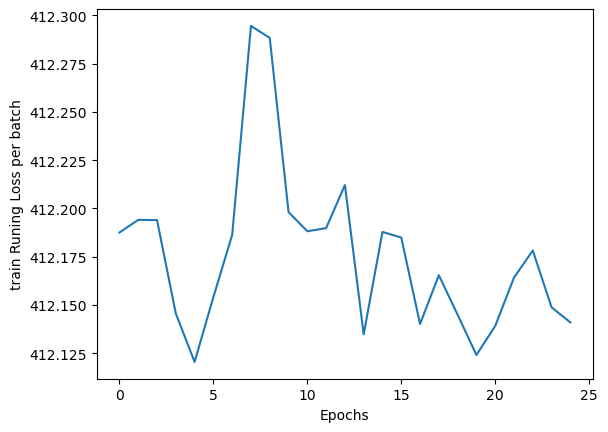

In [61]:
plt.plot(train_loss_list[580:])
plt.xlabel("Epochs")
plt.ylabel("train Runing Loss per batch")
plt.show()

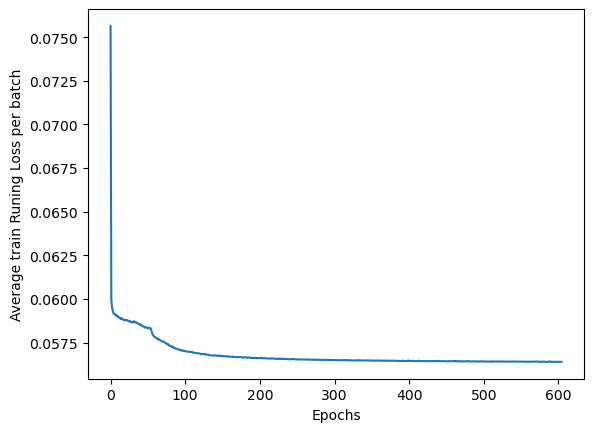

In [55]:
plt.plot(avg_train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average train Runing Loss per batch")
plt.show()

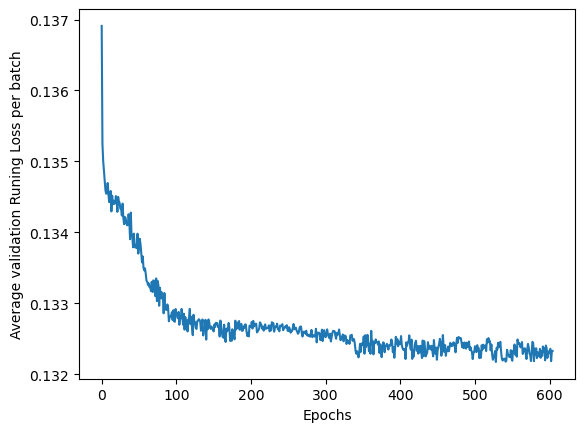

In [63]:
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average validation Runing Loss per batch")
plt.show()

In [22]:
torch.save(final_model_trainset, 'model_100206_7g_03_retrain_trainset.pt')
torch.save(final_model_valset, 'model_100206_7g_03_retrain_valset.pt')

In [23]:
with open('loss_7_03.txt', 'w') as f:
    f.write('train_loss_per_epoch_list: ' + str(train_loss_list) + '\n')
    f.write('\n')
    f.write('avg_train_loss_list: ' + str(avg_train_loss_list) + '\n')
    f.write('\n')
    f.write('val_loss_list: ' + str(val_loss_list) + '\n')